# Drug response study in different canine lymphoma subtypes

### AIM 1: Identifying the different canine lymphoma subtypes in 96 dogs
- The dataset contains reported cell surface markers for different proteins of cancer cells identified using Flow Cytometry.

### AIM 2: Finding the best responsive drug(s) among given 15 different drugs for each of the canine lymphoma subtypes
- The dataset contains the bfLogIC50, bfHillSlope, Rsquare of fit among other parameters of the regression fit. 

# 1. Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats 
from scipy.cluster.vq import kmeans2
import matplotlib.pyplot as plt
import seaborn as sns
import heapq
import warnings
warnings.filterwarnings('ignore')

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import metrics 
from scipy.spatial.distance import cdist 

np.random.seed(123)
pd.set_option('display.max_rows', 100)
pd.options.display.float_format = '{:.3f}'.format

# 2. Reading Data

In [2]:
flow_data = pd.read_excel('data/Flow sample data.xlsx')
imv_data  = pd.read_excel('data/Sample IMV data.xlsx')

# 3. Looking at the data

In [3]:
#Top 5 of flow sample data
flow_data.head()

,Sample ID,Notes,Lymphocytes \n(% of Total),Small Pop. (% of total),Large Pop. (% of total),Small Pop. (% of lymph),Large Pop. (% of lymph),All CD21+,All MHC+,CD21+MHC-,...,CD5+CD45+,CD5+CD45-,CD34+,CD14+,"FSC, Median","FSC, Mean","FSC, Std. Dev.","SSC, Median","SSC, Mean","SSC, Std. Dev."
0,IMV-C300,NaN,28.330,19.100,11.960,67.420,42.217,41.190,87.910,1.550,...,32.240,0.090,6.420,0.000,316.000,339.230,86.370,98.000,111.860,51.420
1,IMV-C301,NaN,25.980,5.920,20.300,22.787,78.137,75.820,83.800,0.710,...,5.990,0.000,15.690,0.160,398.000,393.730,72.400,111.000,119.490,41.260
2,IMV-C302,NaN,43.980,6.460,38.480,14.688,87.494,68.500,96.040,0.850,...,3.400,0.070,3.220,0.180,451.000,441.220,89.720,136.000,140.700,42.270
3,IMV-C304,NaN,31.580,28.000,14.600,88.664,46.232,25.020,69.970,13.360,...,15.750,60.860,3.610,0.080,336.000,339.720,66.240,88.000,94.650,36.620
4,IMV-C305,NaN,44.510,6.760,40.790,15.188,91.642,83.070,90.100,1.690,...,8.950,0.130,5.230,0.120,480.000,465.280,94.080,149.000,150.490,49.520


In [4]:
#Top 5 of IMV sample data
imv_data.head()

,Patient,Measure,Drug 1,Drug 2,Drug 3,Drug 4,Drug 5,Drug 6,Drug 7,Drug 8,Drug 9,Drug 10,Drug 11,Drug 12,Drug 13,Drug 14,Drug 15
0,C400,ReportedVal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,NaN,NaN,NaN,NaN,NaN,NaN
1,C400,bfBottom,NaN,0.103,NaN,0.088,NaN,0.098,0.131,0.097,nan,0.045,0.231,0.076,NaN,NaN,NaN
2,C400,bfTop,NaN,0.799,NaN,0.831,NaN,0.911,0.858,0.968,nan,0.868,1.185,0.722,NaN,NaN,NaN
3,C400,bfLogIC50,NaN,~ 0.8570,NaN,~ 0.9353,NaN,2.632,3.844,3.433,nan,4.007,0.696,3.290,NaN,NaN,NaN
4,C400,bfHillSlope,NaN,~ -5.714,NaN,~ -10.81,NaN,-0.989,-3.252,-3.266,nan,-1.522,-1.015,-1.436,NaN,NaN,NaN


In [5]:
#Bottom 5 of flow sample data
flow_data.tail()

,Sample ID,Notes,Lymphocytes \n(% of Total),Small Pop. (% of total),Large Pop. (% of total),Small Pop. (% of lymph),Large Pop. (% of lymph),All CD21+,All MHC+,CD21+MHC-,...,CD5+CD45+,CD5+CD45-,CD34+,CD14+,"FSC, Median","FSC, Mean","FSC, Std. Dev.","SSC, Median","SSC, Mean","SSC, Std. Dev."
91,IMV-C396,NaN,81.130,18.680,62.450,23.025,76.975,98.410,99.660,0.010,...,5.180,0.140,12.420,0.080,383.000,380.440,71.440,93.000,96.730,27.920
92,IMV-C397,NaN,66.530,31.090,35.440,46.731,53.269,80.200,98.610,0.230,...,24.130,0.030,13.660,0.500,345.000,349.710,86.840,89.000,93.820,36.330
93,IMV-C398,NaN,84.190,29.020,55.170,34.470,65.530,97.730,99.260,0.030,...,2.000,0.130,9.230,0.030,360.000,363.670,62.160,79.000,83.140,23.740
94,IMV-C399,NaN,62.790,15.600,47.190,24.845,75.155,5.260,73.200,0.350,...,97.860,0.070,5.200,0.200,381.000,378.170,80.050,104.000,109.350,33.360
95,IMV-C400,NaN,82.120,21.790,60.600,26.534,73.794,82.270,94.480,0.610,...,19.550,0.050,2.640,0.270,410.000,397.280,80.360,104.000,106.590,35.560


In [6]:
#Bottom 5 of IMV sample data
imv_data.tail()

,Patient,Measure,Drug 1,Drug 2,Drug 3,Drug 4,Drug 5,Drug 6,Drug 7,Drug 8,Drug 9,Drug 10,Drug 11,Drug 12,Drug 13,Drug 14,Drug 15
2207,C300,AbsSumofSquares,NaN,0.031,NaN,0.006,NaN,0.033,NaN,NaN,nan,NaN,0.008,0.003,NaN,NaN,NaN
2208,C300,Sy.x,NaN,0.102,NaN,0.043,NaN,0.128,NaN,NaN,nan,NaN,0.051,0.031,NaN,NaN,NaN
2209,C300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,NaN,NaN,NaN,NaN,NaN,NaN
2210,C300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,NaN,NaN,NaN,NaN,NaN,NaN
2211,C300,NumPoints,NaN,7,NaN,7,NaN,6,NaN,NaN,nan,NaN,7,7,NaN,NaN,NaN


In [7]:
#Viewing the number of rows and columns of flow sample data
flow_data.shape

(96, 29)

In [8]:
#Viewing the number of rows and columns of IMV sample data
imv_data.shape

(2212, 17)

In [9]:
#General information of flow data
flow_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 29 columns):
Sample ID                    96 non-null object
Notes                        4 non-null object
Lymphocytes 
(% of Total)    96 non-null float64
Small Pop. (%  of total)     96 non-null float64
Large Pop. (% of total)      96 non-null float64
Small Pop.  (% of lymph)     96 non-null float64
Large Pop. (% of lymph)      96 non-null float64
All CD21+                    96 non-null float64
All MHC+                     96 non-null float64
CD21+MHC-                    96 non-null float64
CD21+MHC+                    96 non-null float64
CD21-MHC+                    96 non-null float64
All CD3+                     96 non-null float64
All CD4+                     96 non-null float64
All CD8+                     96 non-null float64
CD3+CD4+                     96 non-null float64
CD3+CD8+                     96 non-null float64
All CD5+                     96 non-null float64
CD5-CD45+         

In [10]:
#General information of IMV data
imv_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2212 entries, 0 to 2211
Data columns (total 17 columns):
Patient    2212 non-null object
Measure    2054 non-null object
Drug 1     1188 non-null object
Drug 2     1738 non-null object
Drug 3     1210 non-null object
Drug 4     1738 non-null object
Drug 5     1123 non-null object
Drug 6     1737 non-null object
Drug 7     1497 non-null object
Drug 8     1540 non-null object
Drug 9     0 non-null float64
Drug 10    1650 non-null object
Drug 11    1621 non-null object
Drug 12    1452 non-null object
Drug 13    1298 non-null object
Drug 14    1034 non-null object
Drug 15    1211 non-null object
dtypes: float64(1), object(16)
memory usage: 293.9+ KB


# 4. Calculating Descriptive Statistics

In [11]:
#Calculating descriptive Statistics for flow data
flow_data.describe()
#Looks like flow data is ready for the Explorary Data Analysis.

,Lymphocytes \n(% of Total),Small Pop. (% of total),Large Pop. (% of total),Small Pop. (% of lymph),Large Pop. (% of lymph),All CD21+,All MHC+,CD21+MHC-,CD21+MHC+,CD21-MHC+,...,CD5+CD45+,CD5+CD45-,CD34+,CD14+,"FSC, Median","FSC, Mean","FSC, Std. Dev.","SSC, Median","SSC, Mean","SSC, Std. Dev."
count,96.000,96.000,96.000,96.000,96.000,96.000,96.000,96.000,96.000,96.000,...,96.000,96.000,96.000,96.000,96.000,96.000,96.000,96.000,96.000,96.000
mean,56.593,23.847,33.028,43.277,58.081,62.282,85.095,3.386,52.859,31.950,...,31.236,6.852,10.826,0.507,365.880,367.021,75.103,106.323,111.242,35.651
std,23.061,17.550,18.771,24.088,22.912,32.073,24.372,12.365,35.418,27.994,...,29.648,21.388,13.928,1.192,51.591,44.170,15.396,20.166,19.022,7.548
min,0.310,0.290,0.020,10.348,5.833,0.000,0.000,0.000,0.000,0.150,...,0.000,0.000,0.000,0.000,182.000,190.540,37.670,66.000,70.010,17.980
25%,37.910,11.512,16.725,23.179,40.505,36.065,81.180,0.030,11.170,9.952,...,9.545,0.037,3.692,0.050,326.000,337.558,65.775,91.750,96.515,30.363
50%,63.180,18.745,32.530,35.461,65.238,76.870,97.935,0.145,65.915,22.410,...,19.380,0.130,6.085,0.130,372.000,370.960,75.940,103.750,110.060,35.610
75%,73.278,29.957,50.848,62.615,76.821,88.632,99.338,0.725,84.608,50.788,...,39.758,0.330,13.593,0.300,405.000,397.892,84.045,120.000,123.543,41.025
max,94.220,84.670,70.710,112.739,91.642,98.410,99.960,91.070,97.720,97.520,...,98.340,90.970,93.070,7.650,480.000,465.280,109.640,154.000,153.950,55.640


In [12]:
#Calculaing descriptive Statistic of IMV data
imv_data.describe()
#Looks like imv data needs a deep cleaning.

,Drug 9
count,0.000
mean,nan
std,nan
min,nan
25%,nan
50%,nan
75%,nan
max,nan


# AIM 1: Identifying the different canine lymphoma subtypes in 96 dogs

# 5. Flow Data pre-processing

In [13]:
#Converting flow_data Sample ID column into float and removing duplicates
flow_data['Sample ID'] = flow_data['Sample ID'].str.strip('IMV-C')
flow_data['Sample ID'] = flow_data['Sample ID'].str.rstrip('(redo) ').astype(float)
flow_data = flow_data.drop_duplicates('Sample ID')

# 6. Flow Data Exploratory Data Analysis

In [14]:
#Exploratory Data Analysis stage for flow_data
flow_data.isnull().sum()

Sample ID                      0
Notes                         91
Lymphocytes \n(% of Total)     0
Small Pop. (%  of total)       0
Large Pop. (% of total)        0
Small Pop.  (% of lymph)       0
Large Pop. (% of lymph)        0
All CD21+                      0
All MHC+                       0
CD21+MHC-                      0
CD21+MHC+                      0
CD21-MHC+                      0
All CD3+                       0
All CD4+                       0
All CD8+                       0
CD3+CD4+                       0
CD3+CD8+                       0
All CD5+                       0
CD5-CD45+                      0
CD5+CD45+                      0
CD5+CD45-                      0
CD34+                          0
CD14+                          0
FSC, Median                    0
FSC, Mean                      0
FSC, Std. Dev.                 0
SSC, Median                    0
SSC, Mean                      0
SSC, Std. Dev.                 0
dtype: int64

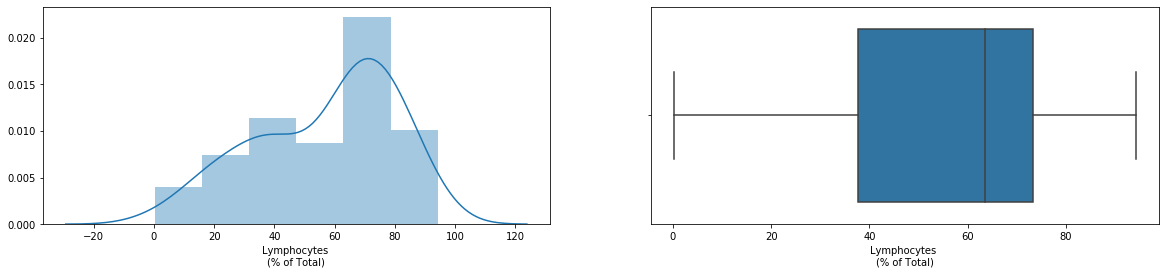

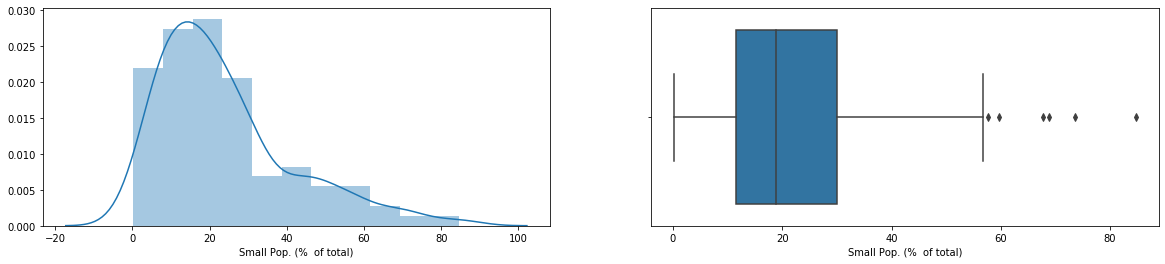

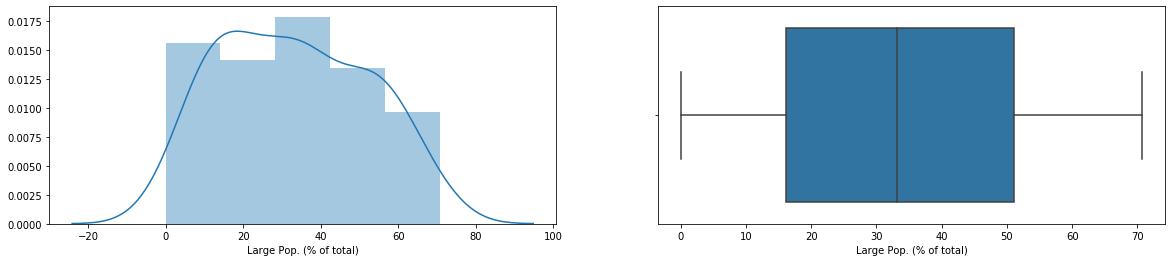

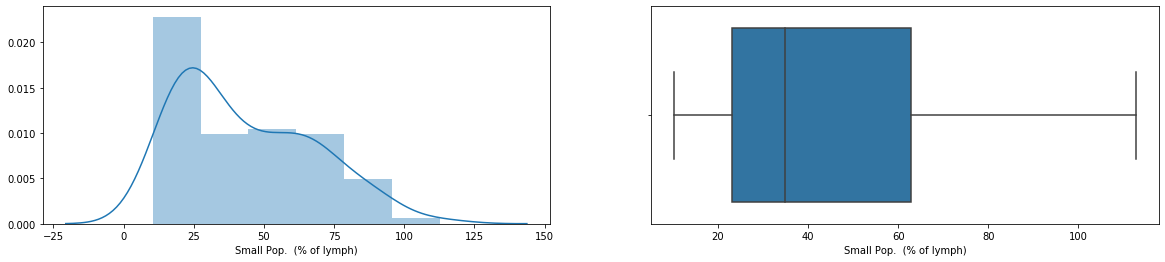

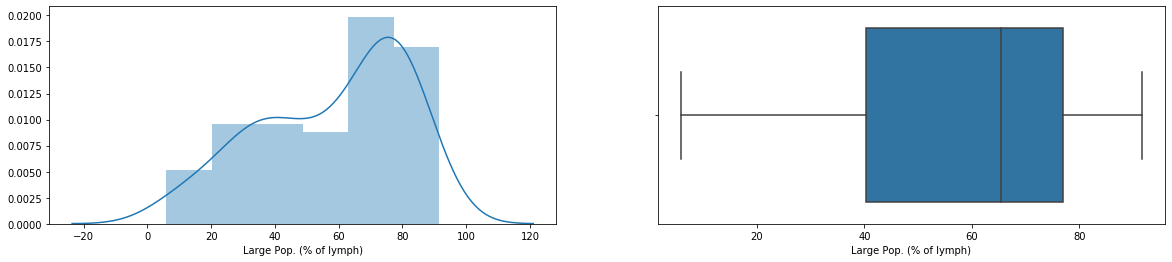

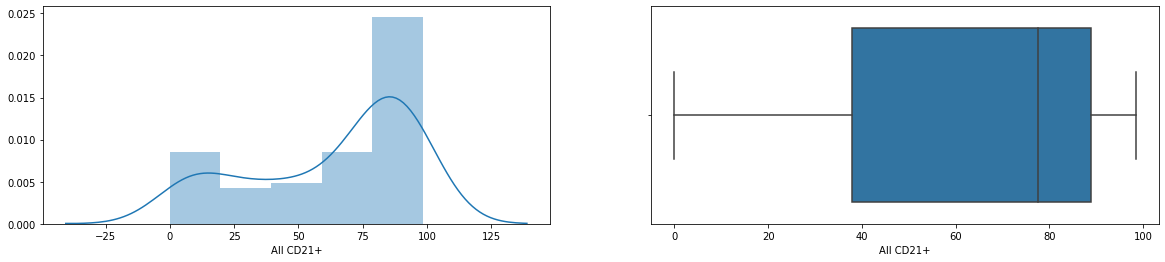

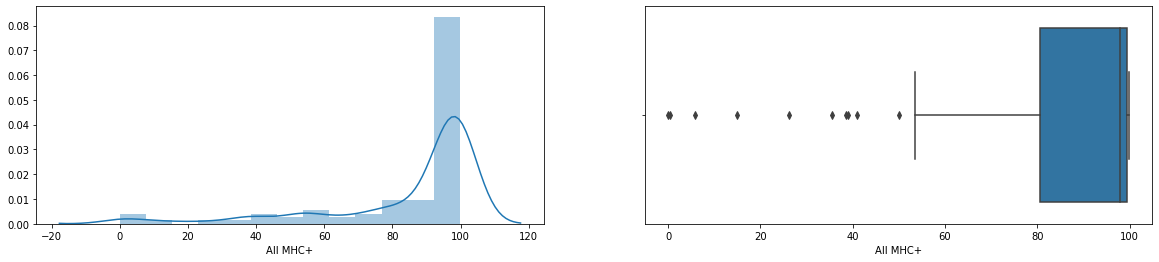

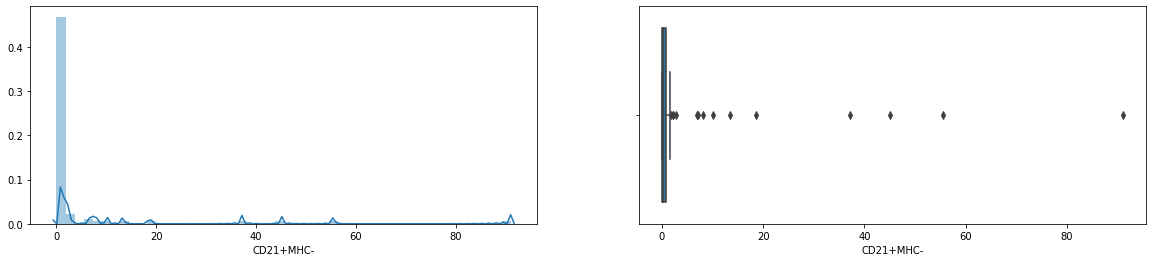

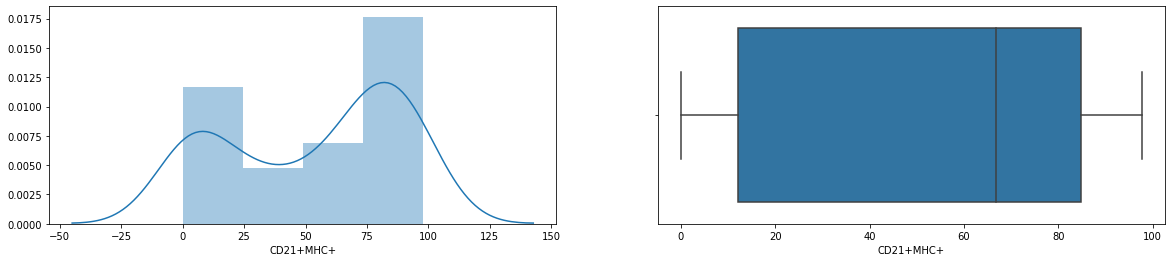

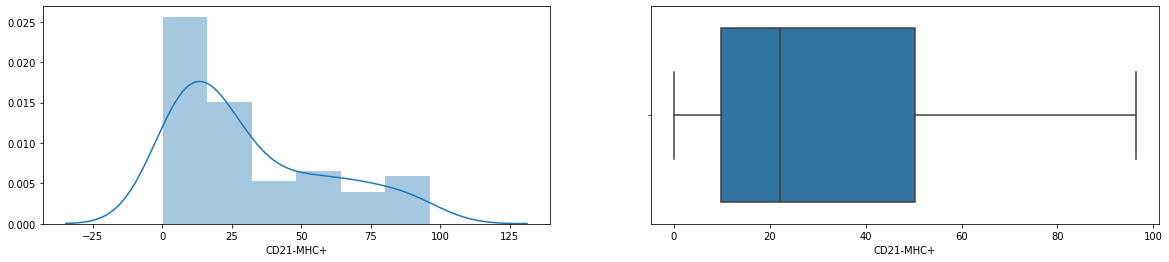

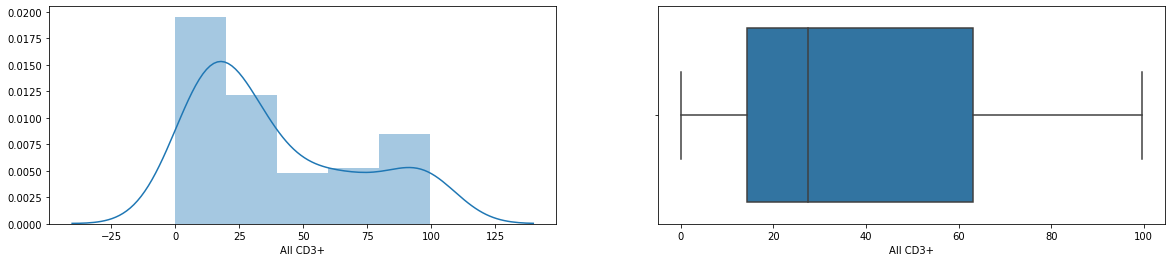

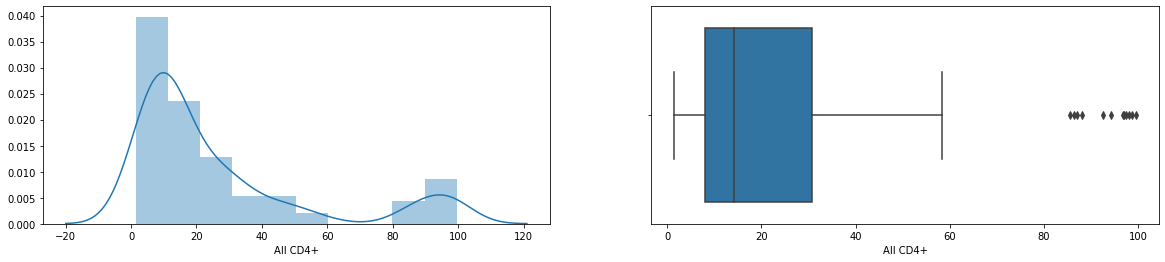

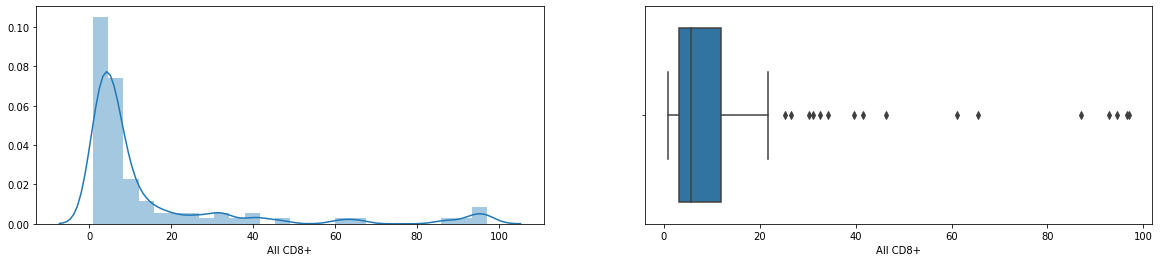

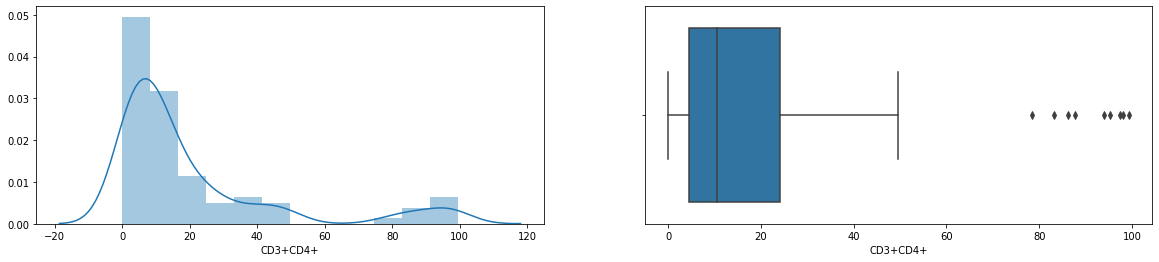

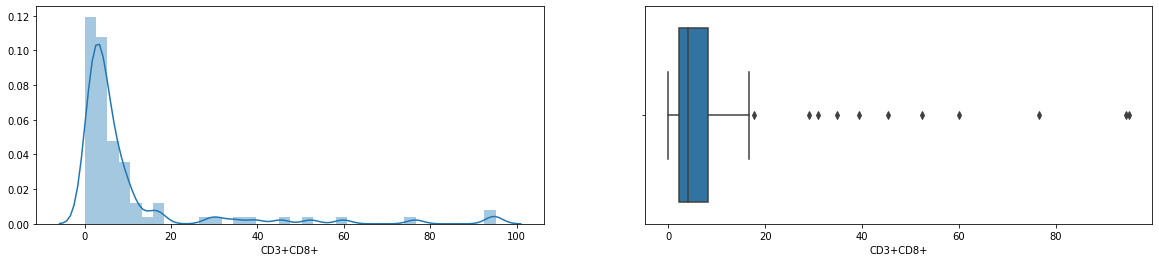

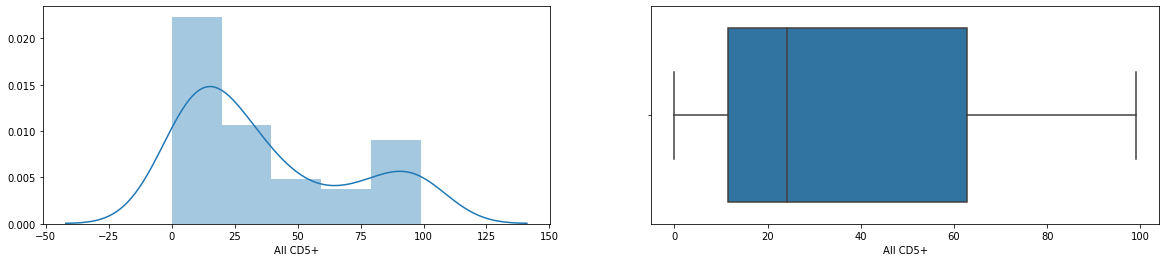

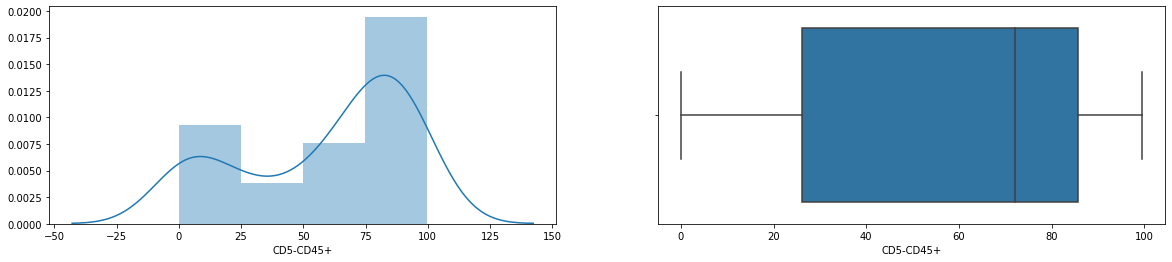

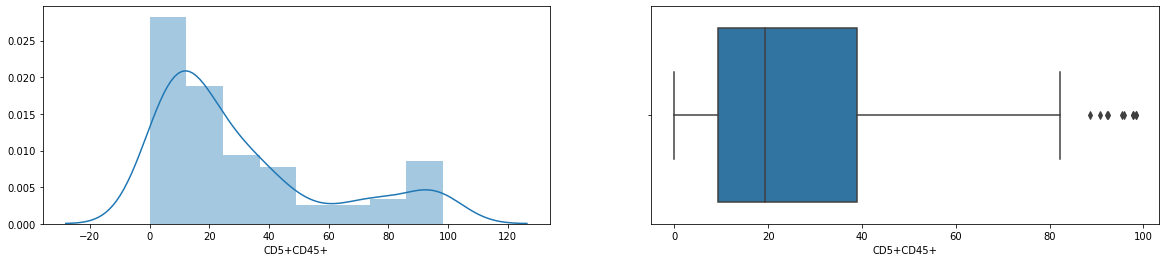

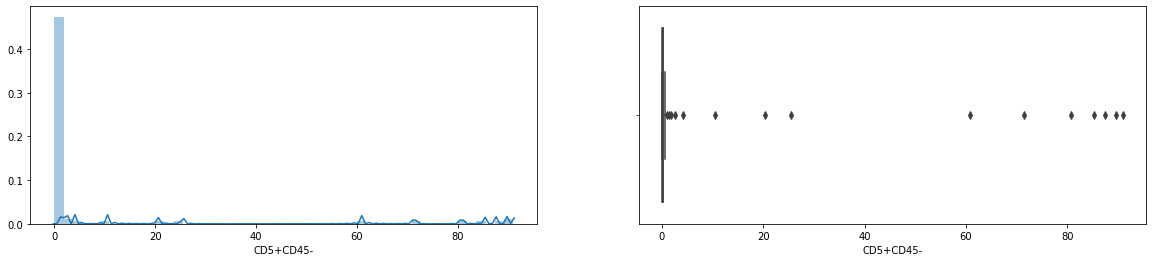

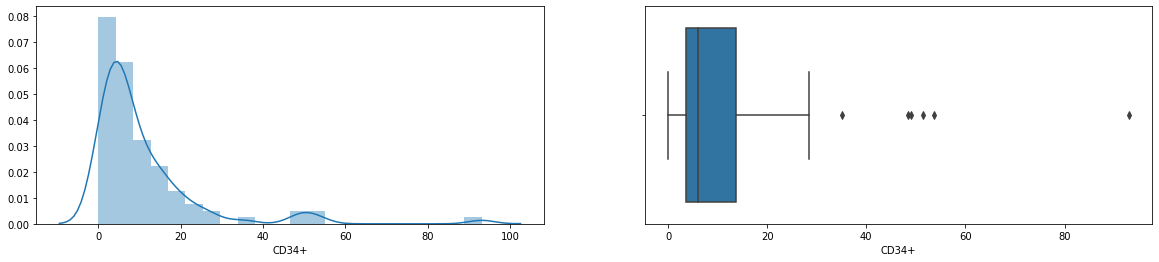

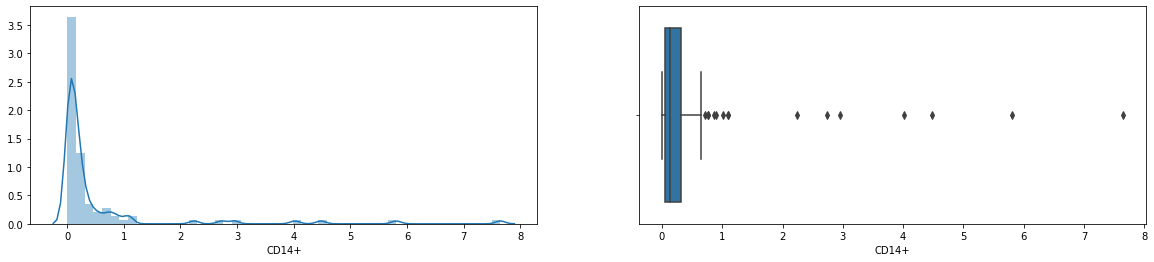

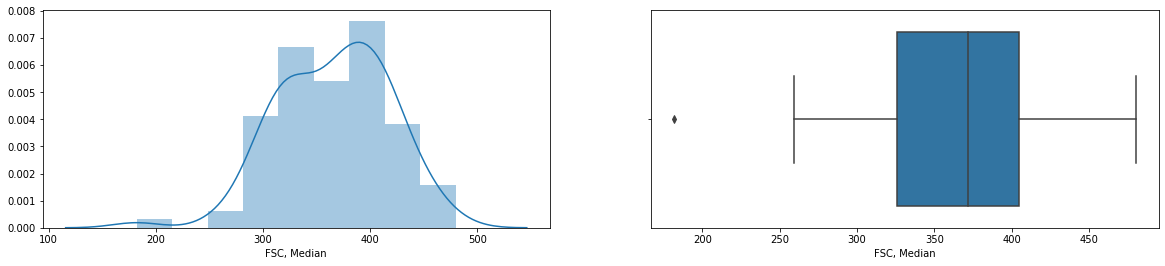

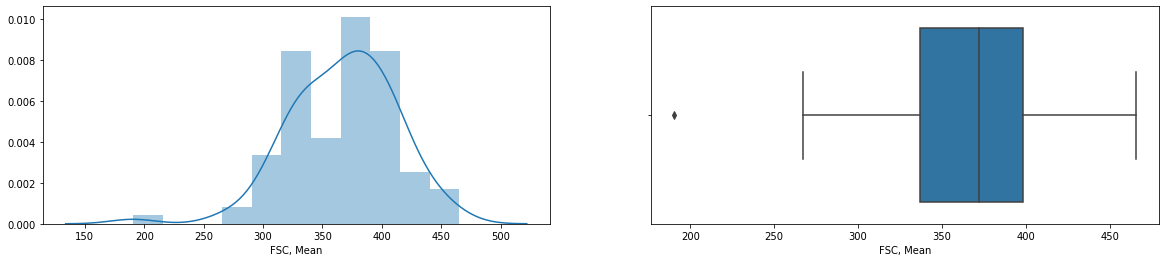

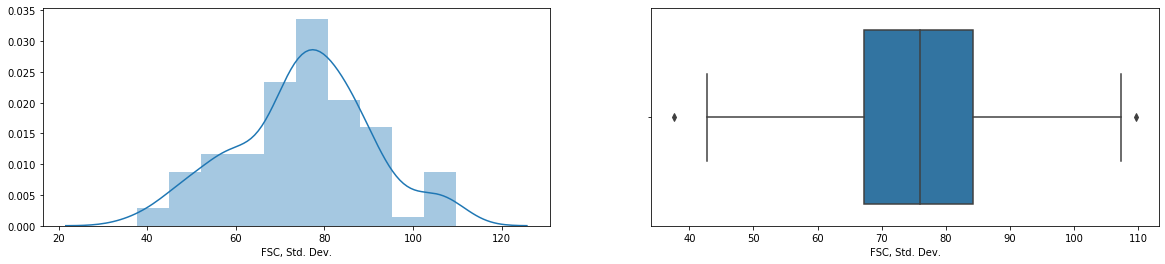

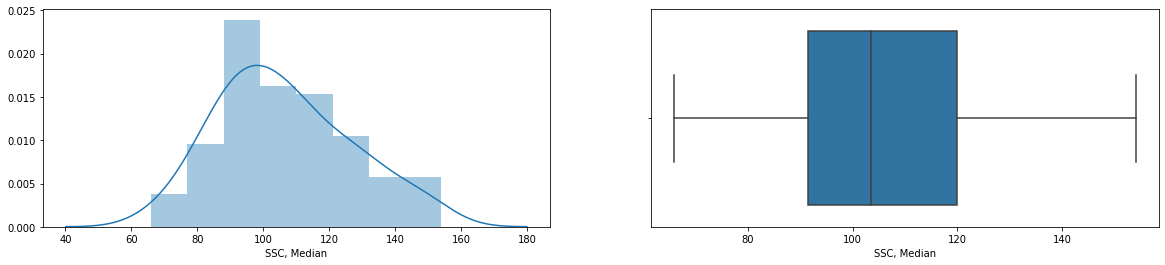

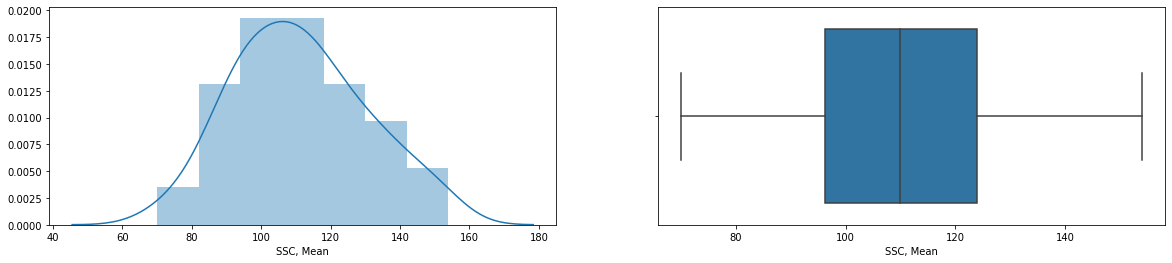

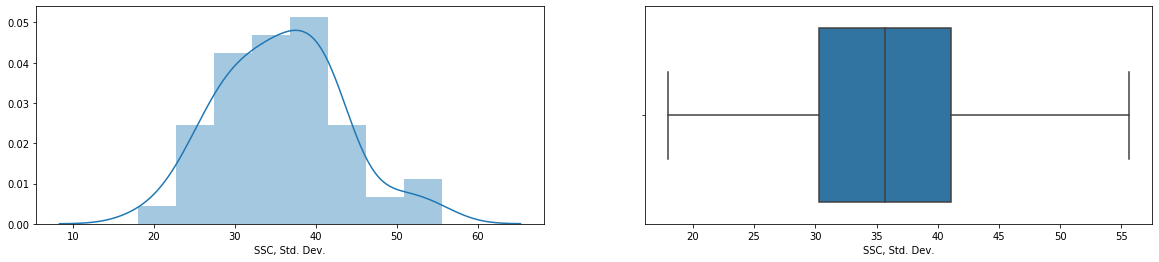

In [15]:
#Univariate analysis of all the features in flow data
for col in range(2,flow_data.shape[1]):
    col_name = flow_data.columns[col]
    f = plt.figure(figsize=(20,4))
    f.add_subplot(1,2,1)
    sns.distplot(flow_data[col_name])
    f.add_subplot(1,2,2)
    sns.boxplot(flow_data[col_name])

In [16]:
#Correlation between features of flow data
flow_data.corr().style.background_gradient().set_precision(2)

,Sample ID,Lymphocytes (% of Total),Small Pop. (% of total),Large Pop. (% of total),Small Pop. (% of lymph),Large Pop. (% of lymph),All CD21+,All MHC+,CD21+MHC-,CD21+MHC+,CD21-MHC+,All CD3+,All CD4+,All CD8+,CD3+CD4+,CD3+CD8+,All CD5+,CD5-CD45+,CD5+CD45+,CD5+CD45-,CD34+,CD14+,"FSC, Median","FSC, Mean","FSC, Std. Dev.","SSC, Median","SSC, Mean","SSC, Std. Dev."
Sample ID,1,0.5,0.23,0.37,-0.058,-0.03,-0.048,-0.0023,-0.017,-0.0085,0.015,0.054,0.031,0.042,0.086,-0.036,0.0092,0.0065,0.048,-0.051,-0.36,-0.05,-0.16,-0.23,0.054,-0.4,-0.47,-0.45
Lymphocytes (% of Total),0.5,1,0.59,0.66,-0.12,0.031,-0.014,0.26,-0.2,0.11,0.097,0.26,0.083,-0.051,0.21,0.085,0.006,0.096,-0.055,0.084,-0.11,-0.19,0.024,-0.003,-0.22,-0.51,-0.56,-0.59
Small Pop. (% of total),0.23,0.59,1,-0.22,0.64,-0.71,-0.31,0.099,-0.12,-0.21,0.36,0.54,0.23,0.2,0.28,0.33,0.34,-0.26,0.14,0.33,-0.14,-0.034,-0.63,-0.62,-0.52,-0.75,-0.76,-0.55
Large Pop. (% of total),0.37,0.66,-0.22,1,-0.73,0.7,0.26,0.21,-0.12,0.32,-0.22,-0.18,-0.11,-0.24,-0.0082,-0.19,-0.3,0.36,-0.2,-0.19,-0.0041,-0.21,0.62,0.58,0.22,0.071,0.028,-0.2
Small Pop. (% of lymph),-0.058,-0.12,0.64,-0.73,1,-0.97,-0.47,-0.21,-0.014,-0.43,0.36,0.46,0.26,0.33,0.21,0.31,0.42,-0.46,0.22,0.34,-0.17,0.13,-0.92,-0.88,-0.52,-0.58,-0.55,-0.19
Large Pop. (% of lymph),-0.03,0.031,-0.71,0.7,-0.97,1,0.47,0.16,0.057,0.4,-0.38,-0.47,-0.29,-0.33,-0.23,-0.3,-0.42,0.47,-0.23,-0.33,0.16,-0.16,0.94,0.91,0.56,0.61,0.59,0.26
All CD21+,-0.048,-0.014,-0.31,0.26,-0.47,0.47,1,0.46,0.12,0.89,-0.74,-0.64,-0.73,-0.25,-0.64,-0.24,-0.55,0.57,-0.57,-0.057,0.2,-0.19,0.51,0.49,0.3,0.17,0.16,0.083
All MHC+,-0.0023,0.26,0.099,0.21,-0.21,0.16,0.46,1,-0.57,0.63,0.092,-0.12,-0.26,-0.16,-0.22,0.15,-0.067,0.16,-0.16,0.12,0.048,-0.17,0.23,0.24,0.044,-0.078,-0.069,-0.084
CD21+MHC-,-0.017,-0.2,-0.12,-0.12,-0.014,0.057,0.12,-0.57,1,-0.23,-0.21,-0.16,-0.13,0.24,-0.12,-0.045,-0.067,0.087,-0.042,-0.045,-0.022,-0.059,0.026,0.034,0.16,0.048,0.036,0.14
CD21+MHC+,-0.0085,0.11,-0.21,0.32,-0.43,0.4,0.89,0.63,-0.23,1,-0.71,-0.54,-0.62,-0.34,-0.54,-0.23,-0.5,0.5,-0.51,-0.061,0.16,-0.23,0.46,0.44,0.22,0.12,0.11,0.018


# 7. Flow Data Clustering 

In [17]:
#Principal components will be passed in the next clustering step
#Principal Component Analysis on the cell surface markeres in the flow_data
flow_pca = flow_data[flow_data.columns[7:23]] #Taking only the cell surface markeres 
pca = PCA(n_components=2)
flow_transformed = pca.fit_transform(flow_pca)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)
print(flow_transformed.shape)

[0.53520451 0.14393022]
[736.20250109 381.78019643]
(95, 2)


Text(0.5, 1.0, 'The Elbow Method using Inertia')

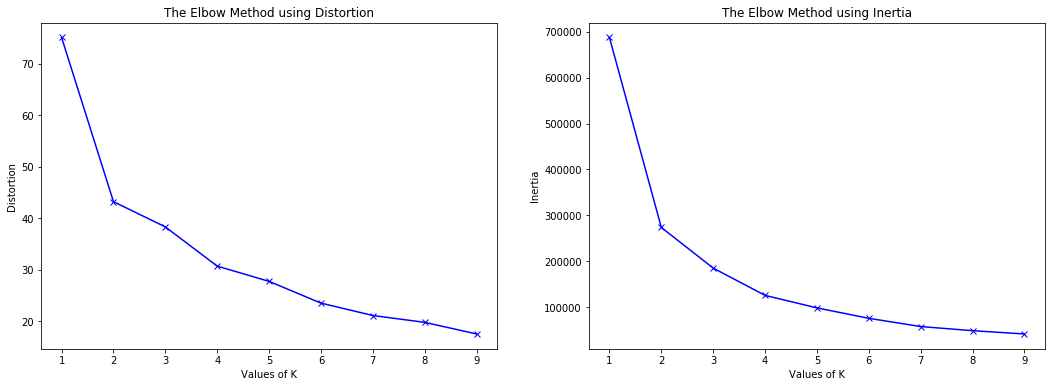

In [18]:
#k-means clustering on the flow_data using its Principal Components
X = flow_transformed
#Identifying the number of clusters using inertia and distortion
distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,10) 
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(X)
      
    #Distortion: It is calculated as the average of the squared distances from the cluster centers of 
    #the respective clusters.
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 
                      'euclidean'),axis = 1)) / X.shape[0]) 
    
    #Inertia: It is the sum of squared distances of samples to their closest cluster center.
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_, 
                 'euclidean'),axis = 1)) / X.shape[0] 
    mapping2[k] = kmeanModel.inertia_ 
    

f = plt.figure(figsize=(18,6))

f.add_subplot(1,2,1)
plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 

f.add_subplot(1,2,2)
plt.plot(K, inertias, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia')  

# 8. Visualizing Clusters 

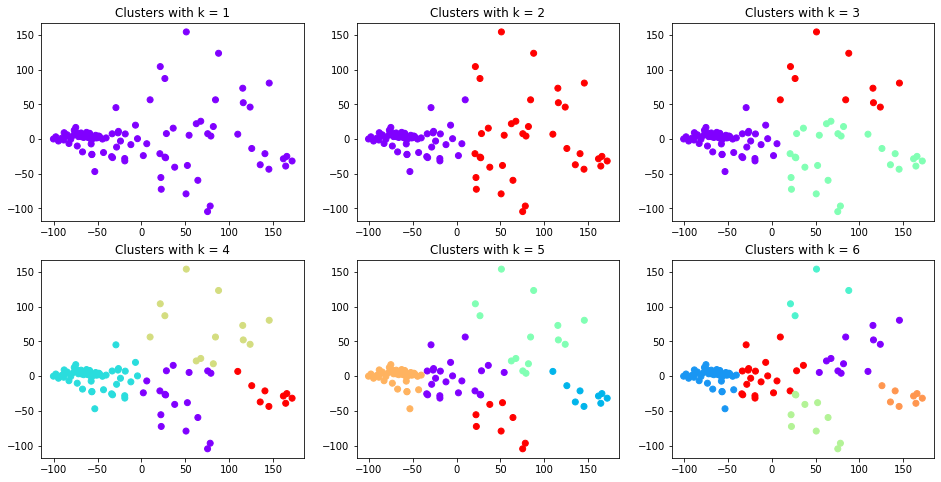

In [19]:
f = plt.figure(figsize=(16,8))
K = range(1,7)  
for k in K: 
    kmeans = KMeans(n_clusters = k).fit(X)
    f.add_subplot(2,3,k)
    scatter=plt.scatter(X[:,0],X[:,1], c = kmeans.labels_, cmap = 'rainbow')
    plt.title('Clusters with k = ' + str(k)) 

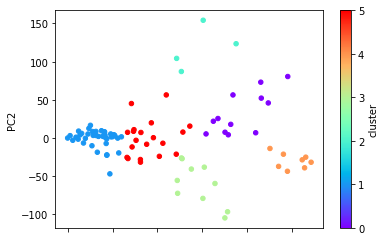

In [20]:
#Settling with 6 clusters and mapping cluster labels
d = pd.DataFrame(X)
d.columns = ['PC1','PC2']
d['cluster'] = kmeans.labels_
d.plot.scatter('PC1', 'PC2', c='cluster', cmap='rainbow')

###### Color code mapping for the clusters based on above plot (will be helpful for further analysis below):
- 0 Magenta
- 1 Blue
- 2 Lime Green
- 3 Seafoam Green
- 4 Orange
- 5 Red

In [21]:
#Cluster centers
print(kmeans.cluster_centers_)

[[ 93.06072427  33.13589409]
 [-67.36541009  -0.46689671]
 [ 46.79456833 117.28153239]
 [ 45.82093095 -60.0049058 ]
 [151.44051219 -30.01597827]
 [-10.58292788  -0.37186047]]


# 9. Percentage of data points in each cluster 

In [22]:
cf = pd.DataFrame({'id' : flow_data['Sample ID'],'cluster' : kmeans.labels_})
print(cf.groupby('cluster').cluster.count()*100/flow_data.shape[0])

cluster
0   12.632
1   43.158
2    4.211
3   10.526
4    8.421
5   21.053
Name: cluster, dtype: float64


### References: 
- Reference1
    A morphological study of 608 cases of canine malignant lymphoma in France  with a focus on comparative similarities between canine and human lymphoma morphology. Ponce and et. al., Vet Pathol. 2010 May;47(3):414-33.
- Reference2
    In vitro drug sensitivity in canine lymphoma. Pawlak and et al., J Vet Res 60, 55-61, 2016.
- Reference3
    Peripheral T cell lymphoma, not otherwise specified: the stuff of genes, dreams and therapies. Agostinelli and et al., J Clin Pathol. 2008 Nov; 61(11): 1160–1167.


### Literature Data:
- Peripheral T cell lymphomas (PTCL) account for about 12% of lymphoid tumours worldwide.
- Immunohistochemistry confirmed 63.8% B-cell (CD3-, CD79a+), 35.4% T-cell (CD3+, CD79a-),and 0.8% null-cell (CD3-, CD79a-) lymphomas.
    - Diffuse large B-cell lymphoma:                           47%
    - Peripheral T-cell not otherwise specified lymphoma:      13%
    - Marginal zone lymphoma (MZL)+ Peripheral B-cell:         24%        
    - Mycosis fungoides:                                        9%
    - T-zone lymphoma:                                          3%
    - Precursor Tcell lymphoma:                                 3%

# 10. Mapping literature values to observed data

In [23]:
#CD21+ is a Marker for B cell lymphomas
cf[cf['id'].isin(list(flow_data[flow_data['All CD21+']>70]['Sample ID']))].groupby('cluster').cluster.count()
#1,5,2? B cell

cluster
1    40
2     3
5    11
Name: cluster, dtype: int64

In [24]:
#Markers of typical B cell lymphomas
cf[cf['id'].isin(list(flow_data[flow_data['CD21+MHC+']>80]['Sample ID']))].groupby('cluster').cluster.count()
#1 is Diffuse large B-cell lymphoma  
#5 is Marginal zone lymphoma (MZL)+ Peripheral B-cell  

cluster
1    26
2     1
5     2
Name: cluster, dtype: int64

In [25]:
#CD21-MHC+ Population of non-B cells that express MHC
cf[cf['id'].isin(list(flow_data[flow_data['CD21-MHC+']>60]['Sample ID']))].groupby('cluster').cluster.count()
#0,2,3 and 4 are T cells lymphomas

cluster
0    9
2    1
3    2
4    4
5    3
Name: cluster, dtype: int64

In [26]:
#CD5+CD45- Very specefic to T zonal 
cf[cf['id'].isin(list(flow_data[flow_data['CD5+CD45-']>90]['Sample ID']))].groupby('cluster').cluster.count()
#2 is T zonal

cluster
2    1
Name: cluster, dtype: int64

In [27]:
#https://www.ncbi.nlm.nih.gov/pubmed/16932019
#Diagnosis of mycosis fungoides: a comparative immunohistochemical 
#study of T-cell markers using a novel anti-CD7 antibody.
#Cotta and et al.,Appl Immunohistochem Mol Morphol. 2006 Sep;14(3):291-5.
#Ballabio et al.[58] found an increased level of miR-223 in CD4+ T cells was
#90% accurate with 91% specificity and 90% sensitivity in correctly predicting 
#diagnosis of SzS compared with MF or healthy controls. 
cf[cf['id'].isin(list(flow_data[flow_data['All CD4+']>80]['Sample ID']))].groupby('cluster').cluster.count()
#4 is MF

cluster
0    1
3    3
4    8
Name: cluster, dtype: int64

In [28]:
#https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5489366/
#The biomarker landscape in mycosis fungoides and Sézary syndrome
#Dulmage and et al., Exp Dermatol. 2017 Aug; 26(8): 668–676.
#Low numbers of CD8+ T cells (<600/mL) have been associated with a worse prognosis in MF/SzS patients
#decreased CD8+ lymphocytes was the best features for differentiation
cf[cf['id'].isin(list(flow_data[flow_data['All CD8+']<5]['Sample ID']))].groupby('cluster').cluster.count()
#4 is MF

cluster
1    22
3     6
4     5
5     7
Name: cluster, dtype: int64

In [29]:
#Peripheral T cell lymphoma, not otherwise specified: the stuff of genes, dreams and therapies
#Agostinelli and et al.,J Clin Pathol. 2008 Nov; 61(11): 1160–1167.
cf[cf['id'].isin(list(flow_data[flow_data['All MHC+']>80]['Sample ID']))].groupby('cluster').cluster.count()
#0 is PTCL

cluster
0    10
1    39
2     4
3     2
4     3
5    13
Name: cluster, dtype: int64

In [30]:
#Peripheral T cell lymphoma, not otherwise specified: the stuff of genes, dreams and therapies
#Agostinelli and et al.,J Clin Pathol. 2008 Nov; 61(11): 1160–1167.
cf[cf['id'].isin(list(flow_data[flow_data['All CD8+']>20]['Sample ID']))].groupby('cluster').cluster.count()
#0 is PTCL

cluster
0    10
2     2
3     1
5     4
Name: cluster, dtype: int64

In [31]:
#An aberrant phenotype with frequent loss of CD5 and/or CD7 was typical for PTCLs
#Marker expression in peripheral T-cell lymphoma: a proposed clinical-pathologic prognostic score.
#Went and et al., J Clin Oncol. 2006 Jun 1;24(16):2472-9. 
cf[cf['id'].isin(list(flow_data[flow_data['All CD5+']<80]['Sample ID']))].groupby('cluster').cluster.count()
#0 is PTCL

cluster
0     8
1    41
3    10
5    19
Name: cluster, dtype: int64

In [32]:
#TDT (-), KIT (+), CD34 (+), CD99 (+) precursor T lymphoblastic leukemia/lymphoma
#Tadashi, Int J Clin Exp Pathol. 2012; 5(2): 167–170.
cf[cf['id'].isin(list(flow_data[flow_data['CD34+']>10]['Sample ID']))].groupby('cluster').cluster.count()
#3 is precursor

cluster
0     2
1    18
3     2
5    10
Name: cluster, dtype: int64

In [33]:
#CD5-CD45+ Some sort of blood cell but not a T cell
cf[cf['id'].isin(list(flow_data[flow_data['CD5-CD45+']>70]['Sample ID']))].groupby('cluster').cluster.count()
#3 Precursor Tcell lymphoma

cluster
1    39
3     4
5     6
Name: cluster, dtype: int64

In [34]:
#All CD5+ Marker of all T cells, expressed in most T cell lymphomas and some rarer forms of B cell lymphoma
cf[cf['id'].isin(list(flow_data[flow_data['All CD5+']>80]['Sample ID']))].groupby('cluster').cluster.count()
#3 Precursor T cell lymphoma

cluster
0    4
2    4
4    8
5    1
Name: cluster, dtype: int64

In [35]:
# Histologically, CD4+ TCL were classified as lymphoblastic or peripheral T cell. 
#Flow Cytometric Characterization and Clinical Outcome of CD4+ T‐Cell Lymphoma in Dogs: 67 Cases
#Avery et al., JVIM, Volume 28, Issue 2
cf[cf['id'].isin(list(flow_data[flow_data['All CD4+']>50]['Sample ID']))].groupby('cluster').cluster.count()
#3 Precursor T cell lymphoma

cluster
0    3
3    3
4    8
Name: cluster, dtype: int64

# Observations:
- In our 95 cases, 61 cases (64.3%) were identified as B-cell lymphoma, and 34 cases (35.7%) were identified as T-cell lymphoma.
- Corresponding literature values are: 63.8% for B-cell and 35.4% for T-cell lymphomas.

# Comparison of literature reported values with observed values:
-    $\;\;\;\;\;\;\;\;$  SUBTYPE $\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;$  ACTUAL $\;\;\;\;\;\;\;\;\;\;\;\;$ OBSERVED
- Diffuse large B-cell lymphoma $\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;$                          47%        $\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;$      43.15%
- Peripheral T-cell not otherwise specified lymphoma $\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;$     13%     $\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;$         12.63%
- Marginal zone lymphoma (MZL)+ Peripheral B-cell $\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;$        24%     $\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;$          21.05%
- Mycosis fungoides          $\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;$                              9%          $\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;$      8.42%
- T-zone lymphoma  $\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;$                                        3%         $\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;$       4.21%
- Precursor T cell lymphoma    $\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;$               3%                 $\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;$            10.52%

# AIM 2: Finding the best responsive drug(s) among given 15 different drugs for each of the canine lymphoma subtypes.  

# 11. IMV Data pre-processing

In [36]:
#Converting imv_data Patient column into float
imv_data['Patient'] = imv_data['Patient'].str.strip('C').astype(float)

# 12. Subsetting IMV Data to take only bfLogIC50 

In [37]:
#Taking only subset of data containing bfLLogIC50, cleaning it and converting it to float
cols_of_interest = ("bfBottom","bfTop","bfLogIC50","bfHillSlope","bfIC50","bfSpan","seLogIC50","DoF","Rsquare","AbsSumofSquares","NumPoints")
imv_sub = imv_data[imv_data.Measure == cols_of_interest[2]].drop(['Measure'],axis=1)
imv_sub = imv_sub.applymap(lambda x: x.strip('~ ') if type(x)==str else x)
imv_sub = imv_sub[imv_sub.columns].apply(pd.to_numeric, errors='coerce', axis=1)
imv_sub.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 79 entries, 3 to 2187
Data columns (total 16 columns):
Patient    79 non-null float64
Drug 1     54 non-null float64
Drug 2     79 non-null float64
Drug 3     55 non-null float64
Drug 4     79 non-null float64
Drug 5     51 non-null float64
Drug 6     79 non-null float64
Drug 7     68 non-null float64
Drug 8     70 non-null float64
Drug 9     0 non-null float64
Drug 10    75 non-null float64
Drug 11    75 non-null float64
Drug 12    66 non-null float64
Drug 13    59 non-null float64
Drug 14    47 non-null float64
Drug 15    59 non-null float64
dtypes: float64(16)
memory usage: 10.5 KB


# 13. EDA on IMV data containing bfLogIC50

In [38]:
print(imv_sub.isnull().sum())
imv_sub.describe()

Patient     0
Drug 1     25
Drug 2      0
Drug 3     24
Drug 4      0
Drug 5     28
Drug 6      0
Drug 7     11
Drug 8      9
Drug 9     79
Drug 10     4
Drug 11     4
Drug 12    13
Drug 13    20
Drug 14    32
Drug 15    20
dtype: int64


,Patient,Drug 1,Drug 2,Drug 3,Drug 4,Drug 5,Drug 6,Drug 7,Drug 8,Drug 9,Drug 10,Drug 11,Drug 12,Drug 13,Drug 14,Drug 15
count,79.000,54.000,79.000,55.000,79.000,51.000,79.000,68.000,70.000,0.000,75.000,75.000,66.000,59.000,47.000,59.000
mean,350.570,0.417,0.583,2.688,1.379,-0.168,3.554,4.618,3.720,nan,4.343,0.713,3.358,3.897,-2.544,-2.367
std,29.175,9.145,1.368,6.162,0.571,0.714,5.337,2.401,1.364,nan,0.262,10.804,0.507,1.312,11.701,11.744
min,300.000,-24.370,-10.620,0.671,0.299,-3.359,1.961,2.883,2.854,nan,3.760,-27.030,2.423,1.710,-53.190,-55.100
25%,324.500,-0.401,0.455,1.222,0.932,-0.344,2.710,3.700,3.321,nan,4.199,0.609,3.152,3.265,0.342,-2.306
50%,352.000,0.229,0.631,1.558,1.319,-0.098,2.952,3.837,3.448,nan,4.319,0.981,3.317,3.641,0.965,-1.983
75%,373.500,1.529,0.990,1.915,1.892,0.156,3.200,4.321,3.636,nan,4.450,1.349,3.537,4.130,1.183,1.208
max,400.000,58.160,2.194,44.090,2.572,1.168,50.190,17.140,12.940,nan,5.379,61.210,6.440,11.950,2.943,23.010


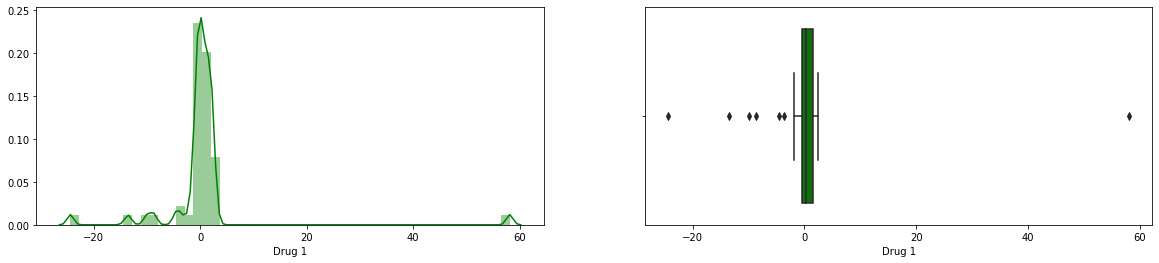

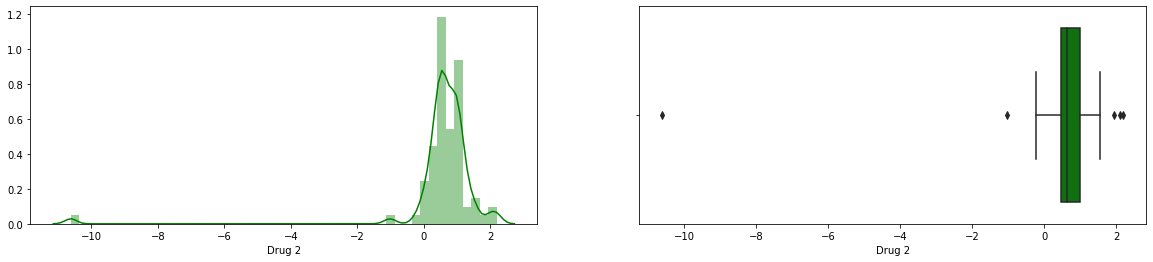

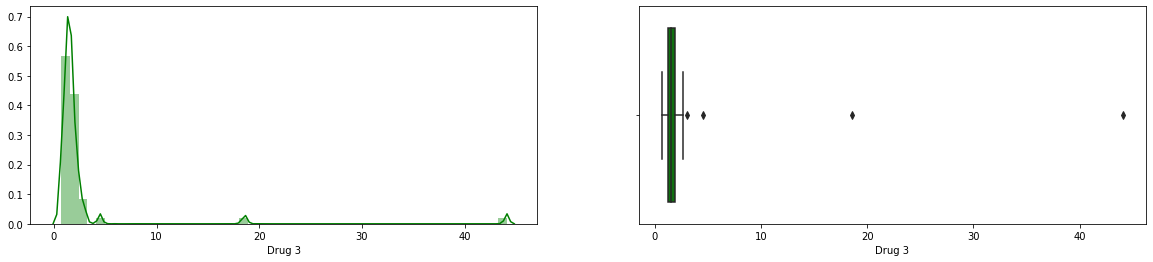

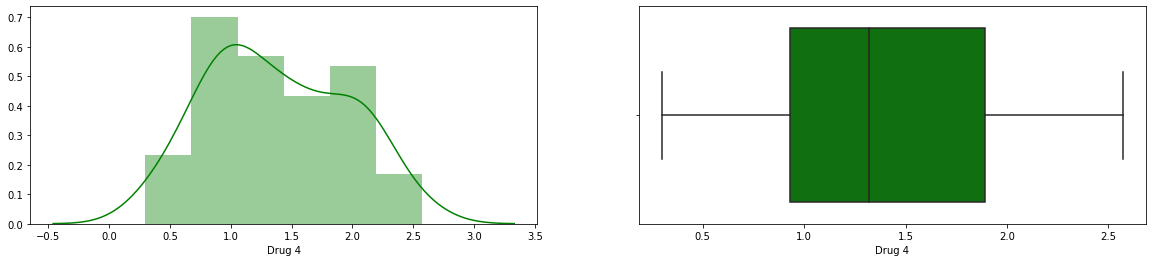

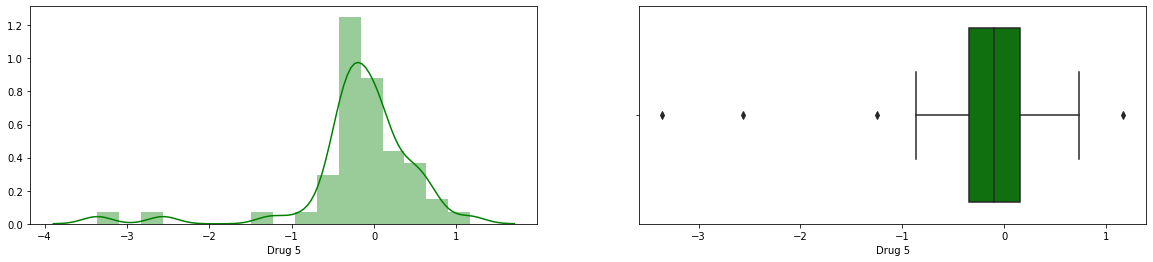

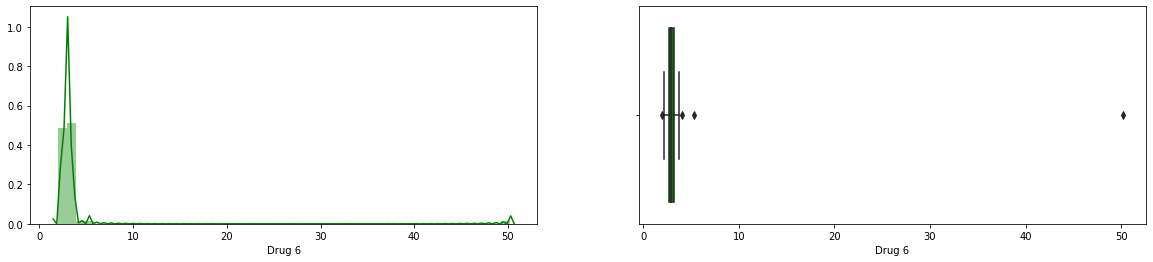

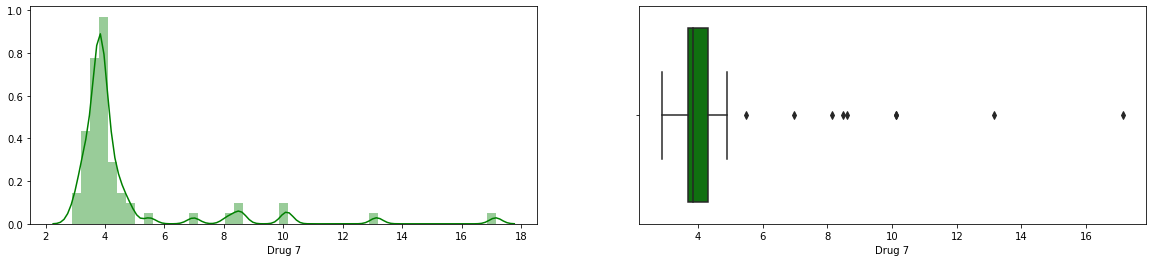

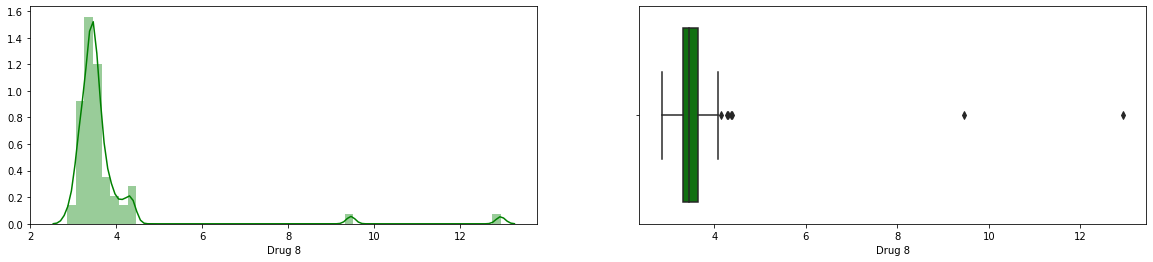

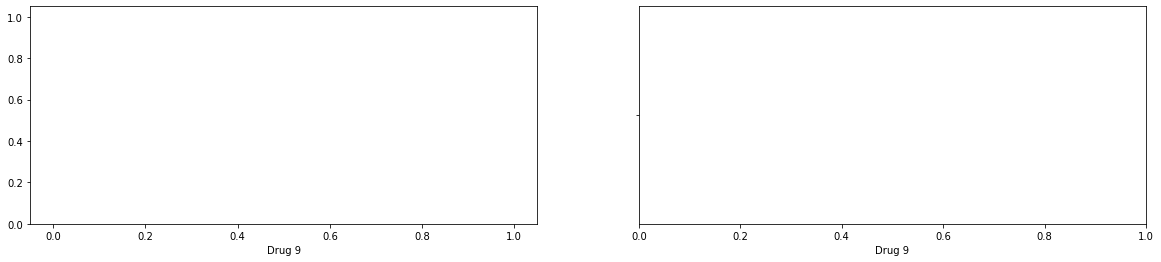

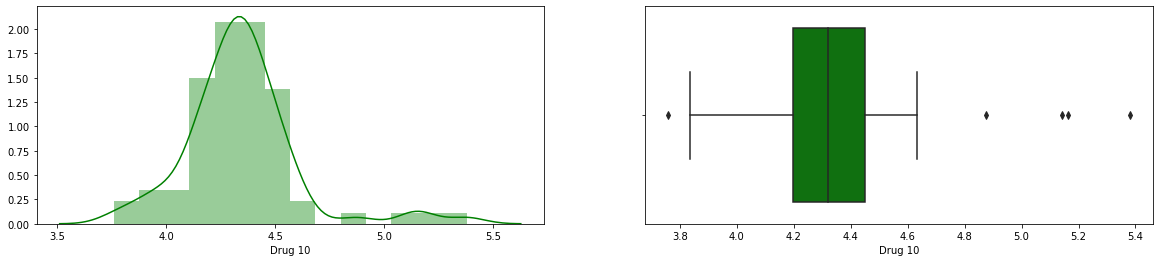

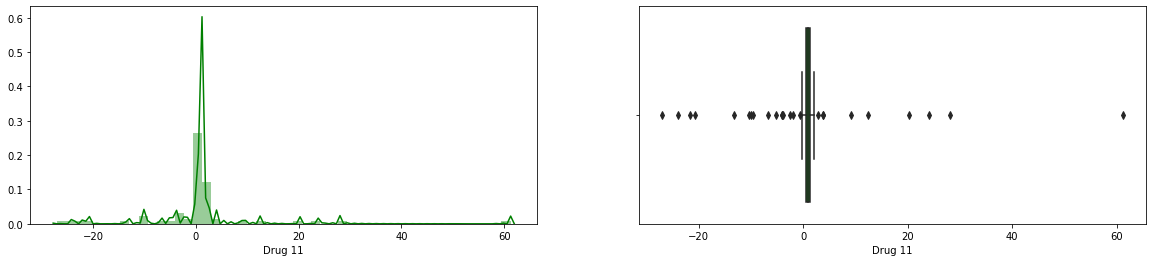

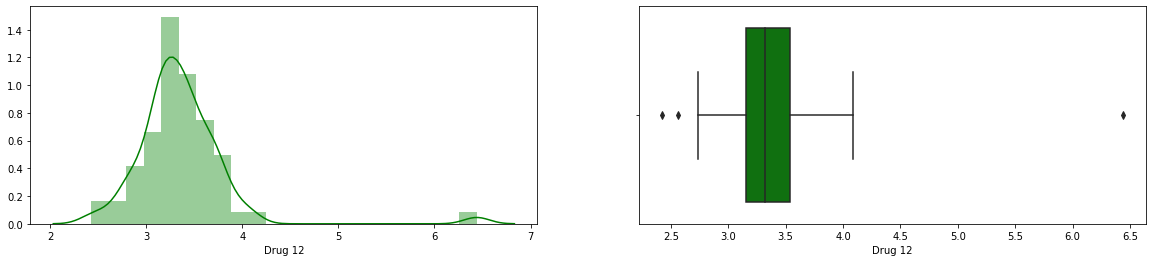

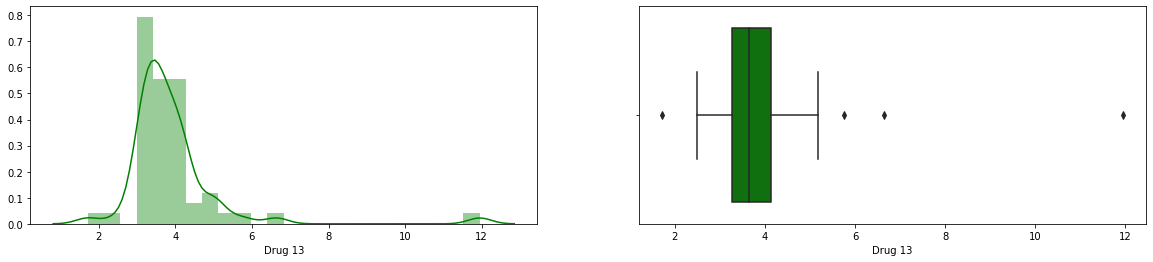

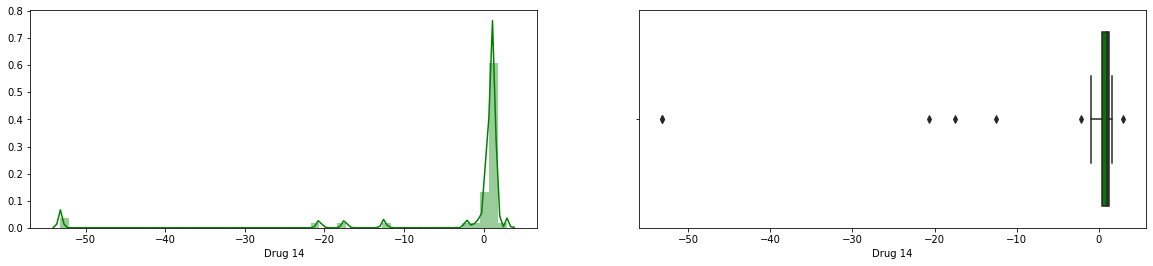

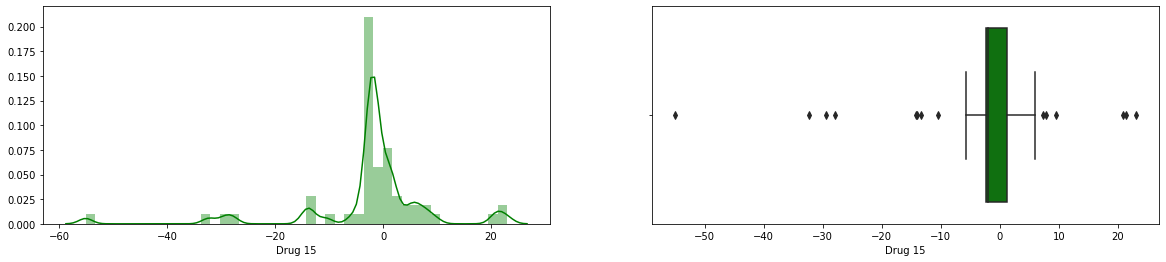

In [39]:
#Univariate analysis of all the features in imv_sub data
for col in range(1,imv_sub.shape[1]):
    col_name = imv_sub.columns[col]
    f = plt.figure(figsize=(20,4))
    f.add_subplot(1,2,1)
    sns.distplot(imv_sub[col_name].dropna(), color='green')
    f.add_subplot(1,2,2)
    sns.boxplot(imv_sub[col_name].dropna(), color='green')

# 14. Joining IMV data's bfLogIC50 values on Flow Data 

In [40]:
#Joining flow_data and imv_sub to get bfLogIC50 for all drugs for each patient/sample id.
df = flow_data.join(imv_sub.set_index('Patient'), on='Sample ID')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95 entries, 0 to 95
Data columns (total 44 columns):
Sample ID                    95 non-null float64
Notes                        4 non-null object
Lymphocytes 
(% of Total)    95 non-null float64
Small Pop. (%  of total)     95 non-null float64
Large Pop. (% of total)      95 non-null float64
Small Pop.  (% of lymph)     95 non-null float64
Large Pop. (% of lymph)      95 non-null float64
All CD21+                    95 non-null float64
All MHC+                     95 non-null float64
CD21+MHC-                    95 non-null float64
CD21+MHC+                    95 non-null float64
CD21-MHC+                    95 non-null float64
All CD3+                     95 non-null float64
All CD4+                     95 non-null float64
All CD8+                     95 non-null float64
CD3+CD4+                     95 non-null float64
CD3+CD8+                     95 non-null float64
All CD5+                     95 non-null float64
CD5-CD45+        

In [41]:
#Taking only the drug cols
df_drugs = df.iloc[:,29:44]
#Merging subtype labels onto the joined dataframe
df_drugs['labels'] = list(kmeans.labels_)
#Calculatin mean and std deviations of the bfLogIC50 values for each lymphoma cell subtype
df_mean = df_drugs.groupby('labels').mean()
df_std  = df_drugs.groupby('labels').std()

In [42]:
#Taking only the drug cols and then making index col 'label' as a regular col.
drug_cols = list(df_mean.columns)
df_mean.reset_index(level=0, inplace=True)
df_std.reset_index(level=0, inplace=True)

# 15. Visualizing each drug's response based on bfLogIC50 

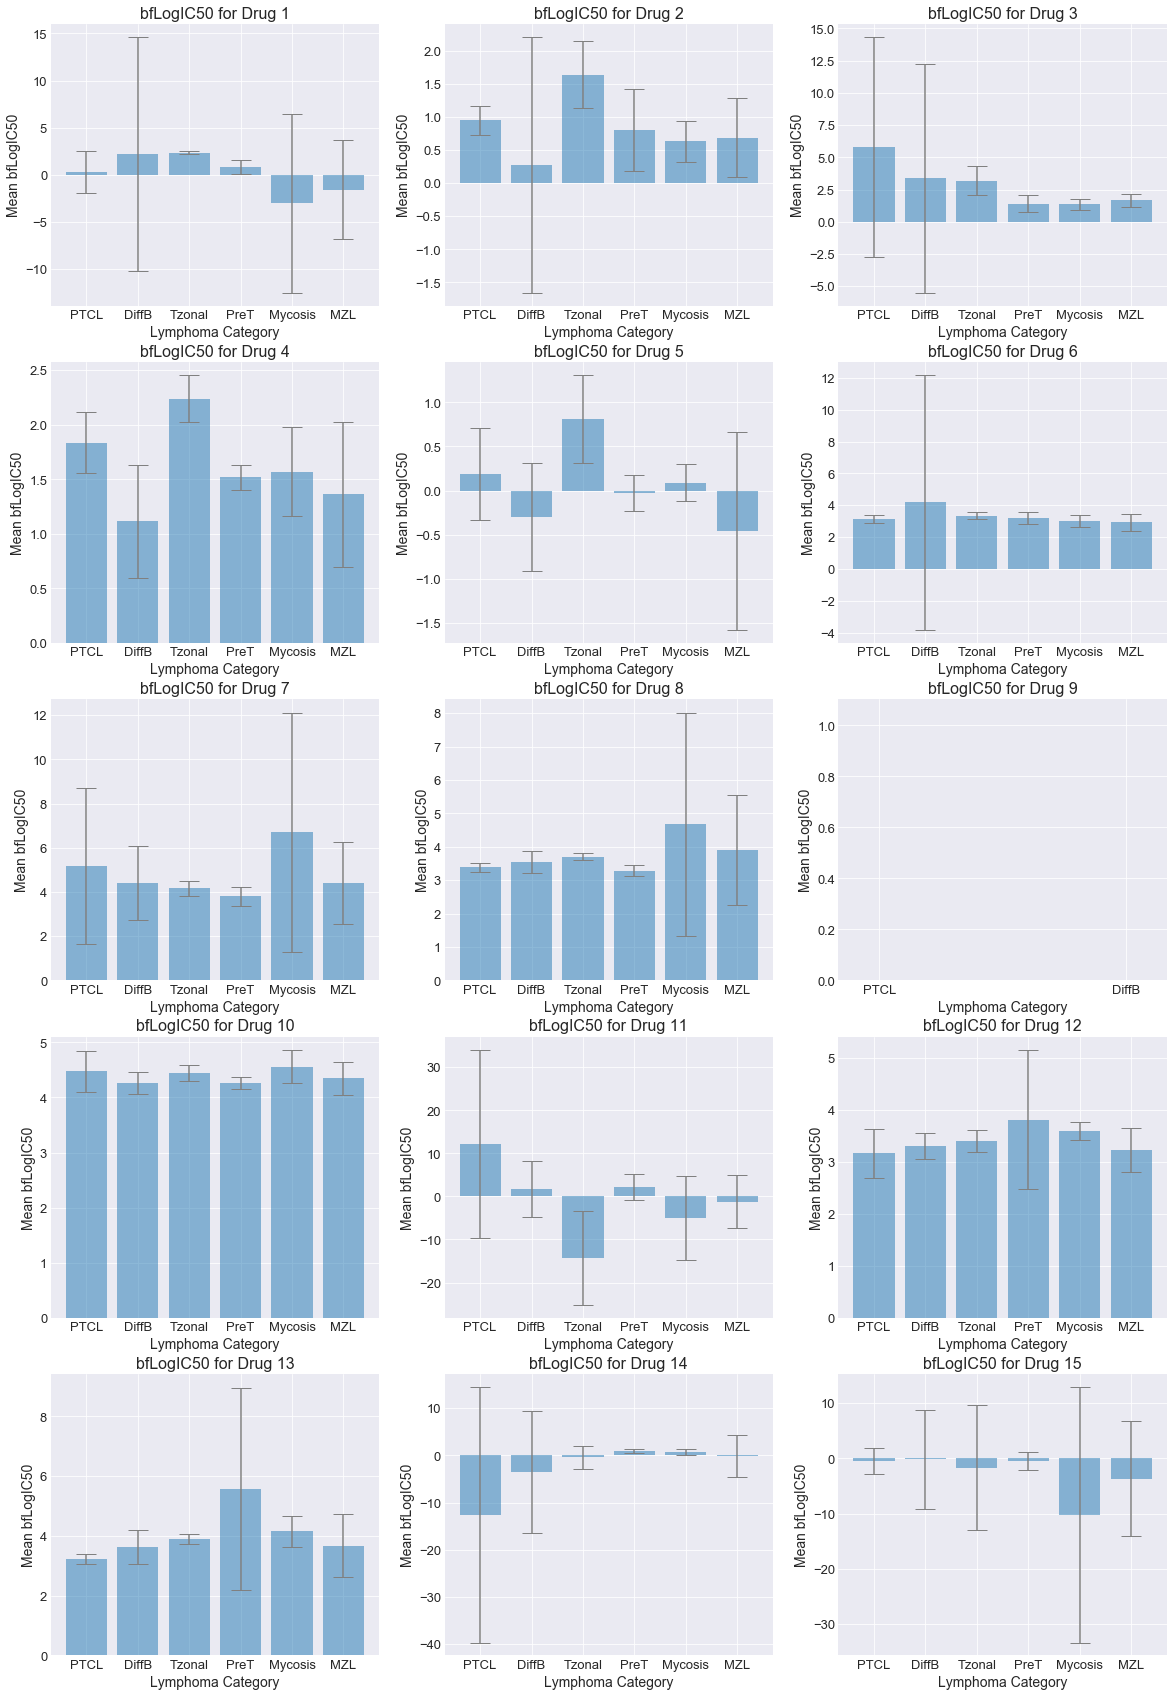

In [43]:
#Initialize the figure
plt.style.use('seaborn-darkgrid')
f = plt.figure(figsize=(20,30))
plt.rcParams.update({'font.size': 13})
label_names = ['PTCL','DiffB','Tzonal','PreT', 'Mycosis', 'MZL']
for col in range(1,df_mean.shape[1]):
    col_name = df_mean.columns[col]
    f.add_subplot(5,3,col)
    plt.bar(label_names, df_mean[col_name],yerr=df_std[col_name],alpha=0.5, ecolor='grey', capsize=10)
    plt.xlabel('Lymphoma Category', fontsize=14)
    plt.ylabel('Mean bfLogIC50', fontsize=14)
    plt.title('bfLogIC50 for Drug ' + str(col),fontsize=16)

# 16. Top 3 responsive drugs based on bfLogIC50

In [44]:
#Looking at the top 3 best responsive drugs in terms of bfLogIC50 for each lymphoma cell subtype
s1 = df_mean.T.apply(lambda x: x.nsmallest(1).idxmax())
s2 = df_mean.T.apply(lambda x: x.nsmallest(2).idxmax())
s3 = df_mean.T.apply(lambda x: x.nsmallest(3).idxmax())
s = pd.concat([s1,s2,s3],axis=1)
s.columns = ['Top1','Top2','Top3']
print(s)

      Top1     Top2     Top3
0  Drug 14  Drug 15   labels
1  Drug 14   Drug 5  Drug 15
2  Drug 11  Drug 15  Drug 14
3  Drug 15   Drug 5   Drug 2
4  Drug 15  Drug 11   Drug 1
5  Drug 15   Drug 1  Drug 11


# Observations: 
- Drug 15 is the best responsive drug based on bfLogIC50 across all the 6 lymphoma subtypes (Refer Appendix-1 for drug classes analysis, if interested)
- The same 5 drugs shows up in top 3 best responsive drug based on bfLogIC50 across all the 6 lyphoma subtypes: Drug 15, Drug 14, Drug 5, Drug 1 and Drug 11 

- Reference 1:
    - In vitro drug sensitivity in canine lymphoma. Pawlak and et al., J Vet Res 60, 55-61, 2016
    - Significant differences in the sensitivity, depending on the drug type, between B-, T- and mixed/null-type lymphoma cells were found for the majority of the tested drugs. B-type cells were the most sensitive in vitro, whereas T-type cells seemed to be the most resistant.
- Reference 2:
    - Flow Cytometric Characterization and Clinical Outcome of CD4+ T‐Cell Lymphoma in Dogs: 67 Cases. (Avery, et al., JVIM. 2014.) 
- Reference 3:
    - The majority of CD4+ TCL were CD45+, expressed low class II MHC, and  exhibited an aggressive clinical course independent of treatment regimen  (median survival, 159 days). Histologically, CD4+ TCL were classified as lymphoblastic or peripheral T cell.
    - Class II MHC expression and Cell Size Independently Predict Survival in Canine B-Cell Lymphoma (Rao, et al., JVIM. 2011.)
- Reference 4:
    - Lack of MHC II expression in B cell lymphomas had a poor outcome. Avery et. Al. Abstract, ACVP Proceedings 2012 
    - T cell lymphomas not expressing CD5 had a better prognosis

# Hypothesis: Is there a difference between drug response based on bfLogIC50 between B and T subtypes in top performing drugs.
- Top responsive drugs: Drug 15, Drug 14, Drug 11, Drug 5 and Drug 1

# 17. Hypothesis Testing

In [45]:
drug_cols = ['Drug 15', 'Drug 14', 'Drug 11', 'Drug 5','Drug 1']
df['labels'] = list(kmeans.labels_)
b_type = df[(df['labels']==1) | (df['labels']==5)]
t_type = df[~((df['labels']==1) | (df['labels']==5))]

In [46]:
#T test hypothesis testing: p value threshold = 0.05.
drug_cols = ['Drug 15', 'Drug 14', 'Drug 11', 'Drug 5','Drug 1'] 
for drug_col in drug_cols:
    print(stats.ttest_ind(a=t_type[drug_col].dropna(),b=b_type[drug_col].dropna(),equal_var=False))

Ttest_indResult(statistic=-0.8757297907163049, pvalue=0.3890019201532112)
Ttest_indResult(statistic=-0.05300409761262332, pvalue=0.9581439479603775)
Ttest_indResult(statistic=-0.06263080263176023, pvalue=0.9504654042075147)
Ttest_indResult(statistic=3.069058960693744, pvalue=0.0035052085839287813)
Ttest_indResult(statistic=-0.655646821121363, pvalue=0.5149547707319055)


# Observations: 
- There is signifcant evidence to prove that Drug 5 have different response between B and T type lymphomas. 
- There is also signifcant evidence to prove that Drug 15, 14, 11 and 1 do not have different response between B and T type lymphomas.

# 18. Summary

# Results:
- We were able to identify 2 major types (B and T) and 6 overall subtypes of canine cell lymphomas in 96 dogs. 
- Drug 15 was found to be the best responsive drug based on bfLogIC50 across all the 6 subtypes of canine cell lymphomas.
- We also observed significant differences in the response (as measured by bfLogIC50) between B and T lymphoma cells for Drug 5.

# Limitations:
- Data Accuracy: The Drug 15's mean Rsquare value is the lowest (0.71) across all the 15 drugs (see Appendix-3). Drug 14 has mean Rsqaure of 0.86 and rest all of the drugs have significantly higher mean Rsqaure values (>0.90).
- The mapping of T cell subtypes with literature values was a little ambiguos, especially for Mycosis fungoides and Precursor Tcell lymphoma. 
- The drug response analysis ideally should be done by comparing the response at different concentrations to get a better understanding of each drug's viability.

# Future Work:
- Predicting the drug resposne based on cell surface markeres. Also identifying translational relations (see Appendix-4) beween different drug responses, if any. 
- To identify if there is a realtion between drug categories (Appendix-1) and lymphoma cell types.
- How does cell size relates to the prognosis of the lymphoma types.

# APPENDIX-1
- PCA & k-means clustering on drug types

In [47]:
#Taking just the drug columns
drug_pca = df.iloc[:,29:45]
drug_pca = drug_pca.drop(['Drug 9','labels'],axis=1)

In [48]:
#PCA
pca = PCA(n_components=2)
drug_transformed = pca.fit_transform(drug_pca.T.notna())
print(pca.explained_variance_ratio_)
print(pca.singular_values_)
print(drug_transformed.shape)

[0.5102709  0.12159154]
[7.46273571 3.64291751]
(14, 2)


Text(0.5, 1.0, 'The Elbow Method using Inertia')

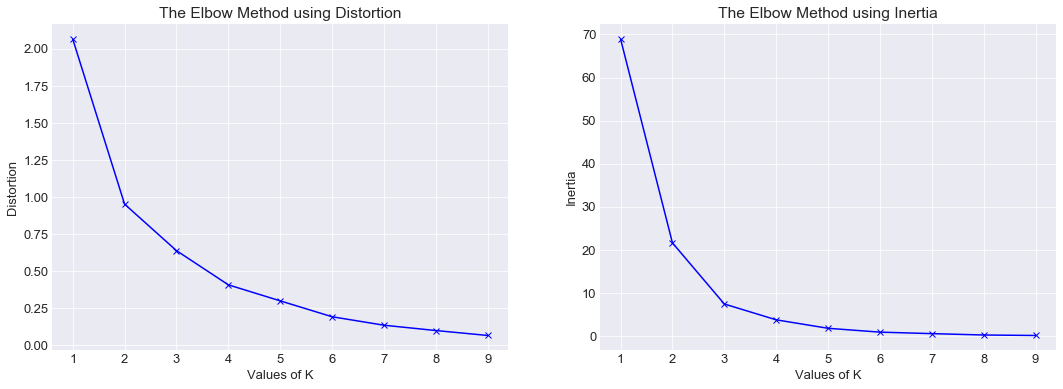

In [49]:
#k-means
X = drug_transformed
distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,10) 
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(X)
      
    #Distortion: It is calculated as the average of the squared distances from the cluster centers of 
    #the respective clusters.
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 
                      'euclidean'),axis = 1)) / X.shape[0]) 
    
    #Inertia: It is the sum of squared distances of samples to their closest cluster center.
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_, 
                 'euclidean'),axis = 1)) / X.shape[0] 
    mapping2[k] = kmeanModel.inertia_ 
    

f = plt.figure(figsize=(18,6))

f.add_subplot(1,2,1)
plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 

f.add_subplot(1,2,2)
plt.plot(K, inertias, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 

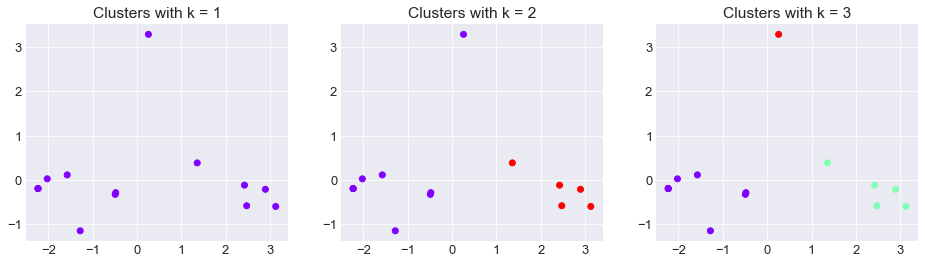

In [50]:
#Visualizing clusters
f = plt.figure(figsize=(16,4))

K = range(1,4)  
for k in K: 
    kmeans = KMeans(n_clusters = k).fit(X)
    f.add_subplot(1,3,k)
    scatter=plt.scatter(X[:,0],X[:,1], c = kmeans.labels_, cmap = 'rainbow')
    plt.title('Clusters with k = ' + str(k)) 

In [51]:
print(kmeans.cluster_centers_)

[[-1.56742223 -0.27184961]
 [ 2.4562286  -0.22127597]
 [ 0.25823489  3.28117669]]


In [52]:
print(kmeans.labels_)

[1 0 1 0 1 0 0 0 0 0 0 1 1 2]


In [53]:
drug_class = pd.concat([pd.DataFrame(drug_pca.T.index), pd.DataFrame(kmeans.labels_)], axis=1)
drug_class.columns = ['Drug','Label']
drug_class
#              0        1        2
#labels                           
#0       Drug 15   Drug 1  Drug 11
#1       Drug 15  Drug 11   Drug 1
#2       Drug 14  Drug 15   Drug 5
#3       Drug 14   Drug 5  Drug 15
#4       Drug 15   Drug 5   Drug 1
#5       Drug 11  Drug 15  Drug 14

,Drug,Label
0,Drug 1,1
1,Drug 2,0
2,Drug 3,1
3,Drug 4,0
4,Drug 5,1
5,Drug 6,0
6,Drug 7,0
7,Drug 8,0
8,Drug 10,0
9,Drug 11,0


# APPENDIX-2
- HillSlope analysis

              0        1        2
labels                           
0       Drug 15   Drug 6  Drug 10
1       Drug 15   Drug 6  Drug 10
2       Drug 15  Drug 10   Drug 4
3       Drug 15  Drug 14  Drug 12
4       Drug 15  Drug 14   Drug 7
5       Drug 10   Drug 4   Drug 5


,Sample ID,Lymphocytes \n(% of Total),Small Pop. (% of total),Large Pop. (% of total),Small Pop. (% of lymph),Large Pop. (% of lymph),All CD21+,All MHC+,CD21+MHC-,CD21+MHC+,...,Drug 7,Drug 8,Drug 9,Drug 10,Drug 11,Drug 12,Drug 13,Drug 14,Drug 15,labels
count,95.000,95.000,95.000,95.000,95.000,95.000,95.000,95.000,95.000,95.000,...,68.000,70.000,0.000,75.000,75.000,66.000,59.000,47.000,59.000,95.000
mean,351.274,56.717,23.919,33.083,43.333,58.040,62.868,84.938,3.421,53.390,...,-2.778,-2.227,nan,-3.544,-1.700,-2.525,-1.664,-4.484,-26.667,2.221
std,28.933,23.152,17.629,18.862,24.210,23.030,31.723,24.453,12.426,35.220,...,5.882,1.860,nan,4.477,2.167,3.240,1.502,10.100,107.068,1.805
min,300.000,0.310,0.290,0.020,10.348,5.833,0.000,0.000,0.000,0.000,...,-47.230,-12.300,nan,-31.420,-8.609,-22.600,-10.920,-57.480,-653.100,0.000
25%,326.500,37.700,11.455,16.130,23.128,40.265,37.880,80.640,0.030,12.190,...,-2.243,-2.507,nan,-3.201,-1.494,-2.504,-2.055,-4.363,-9.047,1.000
50%,352.000,63.570,18.810,33.080,34.835,65.310,77.510,97.930,0.150,66.780,...,-1.590,-1.665,nan,-1.957,-0.969,-1.603,-1.540,-1.198,-1.486,1.000
75%,375.500,73.415,29.965,51.065,62.896,76.872,88.945,99.330,0.740,84.805,...,-1.065,-1.332,nan,-1.450,-0.420,-1.124,-0.751,-0.689,-0.268,4.000
max,400.000,94.220,84.670,70.710,112.739,91.642,98.410,99.910,91.070,97.720,...,-0.190,-0.245,nan,-0.418,-0.021,-0.184,-0.151,-0.019,4.828,5.000


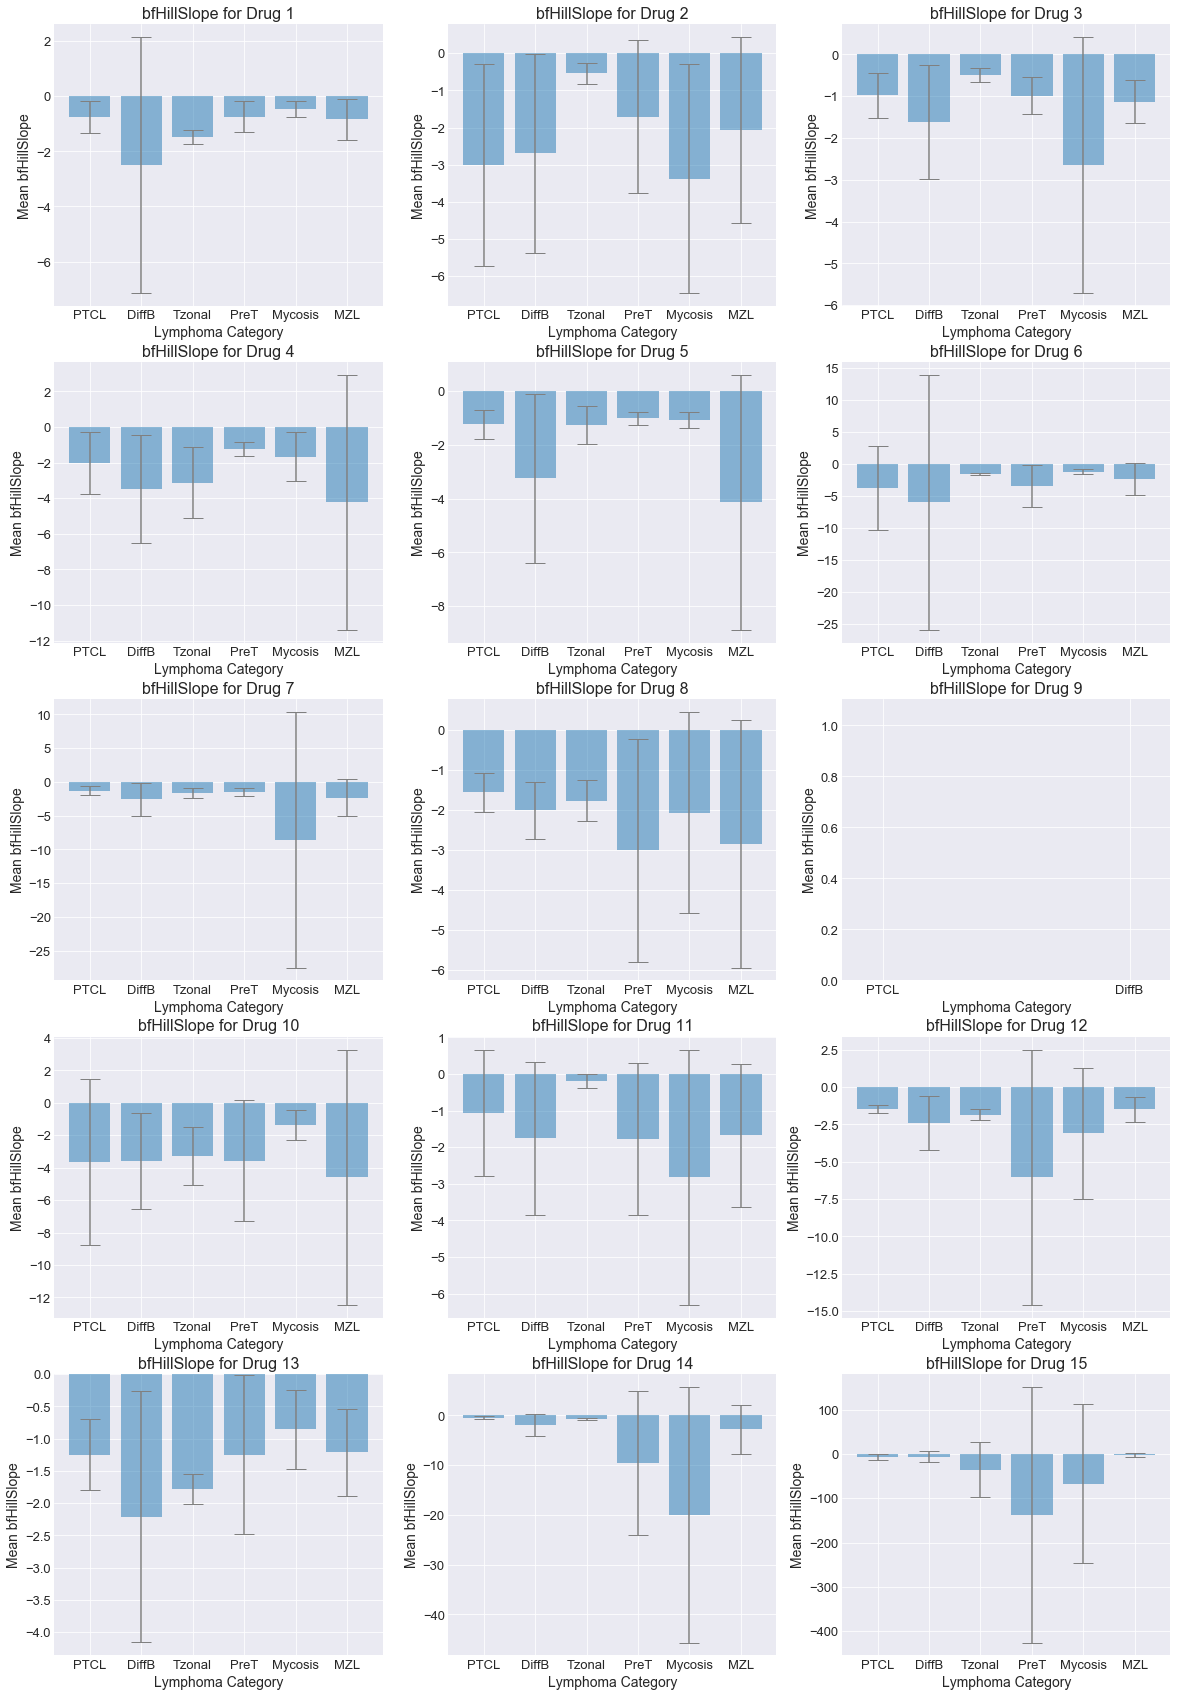

In [54]:
#Subsetting only for bfHillSlope
cols_of_interest = ("bfBottom","bfTop","bfLogIC50","bfHillSlope","bfIC50","bfSpan","seLogIC50","DoF","Rsquare","AbsSumofSquares","NumPoints")
imv_sub = imv_data[imv_data.Measure == cols_of_interest[3]].drop(['Measure'],axis=1)
imv_sub = imv_sub.applymap(lambda x: x.strip('~ ') if type(x)==str else x)
imv_sub = imv_sub[imv_sub.columns].apply(pd.to_numeric, errors='coerce', axis=1)

df_hill = flow_data.join(imv_sub.set_index('Patient'), on='Sample ID')
df_hill['labels'] = df['labels']
dhill_mean = df_hill.groupby('labels').mean()
dhill_std  = df_hill.groupby('labels').std()
dhill_mean = dhill_mean.iloc[:,28:43]
sh1 = dhill_mean.T.apply(lambda x: x.nsmallest(1).idxmax())
sh2 = dhill_mean.T.apply(lambda x: x.nsmallest(2).idxmax())
sh3 = dhill_mean.T.apply(lambda x: x.nsmallest(3).idxmax())
print(pd.concat([sh1,sh2,sh3],axis=1))
dhill_mean.reset_index(level=0, inplace=True)
dhill_std.reset_index(level=0, inplace=True)


f = plt.figure(figsize=(20,30))
plt.rcParams.update({'font.size': 13})
for col in range(1,dhill_mean.shape[1]):
    col_name = dhill_mean.columns[col]
    f.add_subplot(5,3,col)
    plt.bar(label_names, dhill_mean[col_name],yerr = dhill_std[col_name],alpha=0.5, ecolor='grey', capsize=10)
    plt.xlabel('Lymphoma Category', fontsize=14)
    plt.ylabel('Mean bfHillSlope', fontsize=14)
    plt.title('bfHillSlope for Drug ' + str(col),fontsize=16)
    
df_hill.describe()


# APPENDIX-3
- Rsquare analysis

In [55]:
#Subsetting only for Rsquare
cols_of_interest = ("bfBottom","bfTop","bfLogIC50","bfHillSlope","bfIC50","bfSpan","seLogIC50","DoF","Rsquare","AbsSumofSquares","NumPoints")
imv_sub = imv_data[imv_data.Measure == cols_of_interest[8]].drop(['Measure'],axis=1)
imv_sub = imv_sub.applymap(lambda x: x.strip('~ ') if type(x)==str else x)
imv_sub = imv_sub[imv_sub.columns].apply(pd.to_numeric, errors='coerce', axis=1)

df_rsquare = flow_data.join(imv_sub.set_index('Patient'), on='Sample ID')
df_rsquare['labels'] = df['labels']
df_rsquare.iloc[:,29:44].describe()

,Drug 1,Drug 2,Drug 3,Drug 4,Drug 5,Drug 6,Drug 7,Drug 8,Drug 9,Drug 10,Drug 11,Drug 12,Drug 13,Drug 14,Drug 15
count,54.000,79.000,55.000,79.000,51.000,79.000,68.000,70.000,0.000,75.000,73.000,66.000,59.000,47.000,53.000
mean,0.965,0.971,0.953,0.981,0.978,0.936,0.918,0.963,nan,0.978,0.900,0.979,0.953,0.865,0.719
std,0.039,0.036,0.062,0.022,0.026,0.095,0.127,0.081,nan,0.027,0.134,0.024,0.064,0.160,0.259
min,0.819,0.772,0.629,0.876,0.865,0.499,0.311,0.472,nan,0.853,0.340,0.877,0.664,0.291,0.152
25%,0.957,0.964,0.955,0.978,0.972,0.926,0.919,0.972,nan,0.970,0.879,0.976,0.938,0.828,0.516
50%,0.974,0.982,0.972,0.989,0.987,0.979,0.961,0.989,nan,0.991,0.951,0.987,0.979,0.929,0.835
75%,0.989,0.994,0.984,0.995,0.993,0.991,0.982,0.994,nan,0.993,0.979,0.992,0.992,0.972,0.938
max,0.998,1.000,0.999,1.000,0.999,0.999,0.996,0.999,nan,0.999,0.999,0.999,0.999,0.997,0.997


# APPENDIX-4
- Translational relations between different drug responses

In [56]:
#Correlation between different drug responses: 
df_drugs.drop(['Drug 9','labels'],axis=1).corr().style.background_gradient().set_precision(2)

,Drug 1,Drug 2,Drug 3,Drug 4,Drug 5,Drug 6,Drug 7,Drug 8,Drug 10,Drug 11,Drug 12,Drug 13,Drug 14,Drug 15
Drug 1,1,-0.051,0.82,0.23,0.29,-0.021,0.031,0.041,0.17,0.08,0.12,0.11,0.0096,0.27
Drug 2,-0.051,1,0.02,0.11,0.11,-0.029,0.071,-0.074,0.074,-0.026,-0.087,-0.09,-0.049,0.049
Drug 3,0.82,0.02,1,0.15,0.11,-0.025,-0.066,-0.045,0.11,0.27,0.026,-0.013,0.049,0.03
Drug 4,0.23,0.11,0.15,1,0.59,0.023,0.26,0.34,0.43,0.0027,0.26,0.22,-0.24,0.0065
Drug 5,0.29,0.11,0.11,0.59,1,-0.018,0.075,0.14,0.17,-0.12,0.048,0.1,-0.25,0.035
Drug 6,-0.021,-0.029,-0.025,0.023,-0.018,1,-0.011,-0.0067,-0.042,-0.041,0.044,-0.00049,0.036,0.0046
Drug 7,0.031,0.071,-0.066,0.26,0.075,-0.011,1,0.64,0.38,0.0023,0.23,0.093,0.071,0.052
Drug 8,0.041,-0.074,-0.045,0.34,0.14,-0.0067,0.64,1,0.46,-0.017,0.13,0.094,-0.043,0.021
Drug 10,0.17,0.074,0.11,0.43,0.17,-0.042,0.38,0.46,1,-0.048,0.29,0.2,-0.076,-0.011
Drug 11,0.08,-0.026,0.27,0.0027,-0.12,-0.041,0.0023,-0.017,-0.048,1,-0.13,0.025,-0.12,0.14


### Highly correlated drug response rates: 
- 1 and 3   (0.82)
- 4 and 5   (0.59)
- 7 and 8   (0.64)
- 12 and 13 (0.81)